En este ejercicio utilizaremos un dataset con indicadores de la calidad del aire (AQI) del Gobierno de India. El objetivo es realizar un forecast de los valores de este indicador para los proximos n meses futuros. <br>
Para ello utilizaremos modelos de Series Temporales, concretamente veremos y compararemos los siguientes modelos:
* SARIMA
* FB Prophet
* Regresión

# Import libraries

**NOTA**: Cualquier librería que no este disponible en tu entorno Colab ejecuta la siguiente línea con el nombre de la librería (libname) para instalarla:<br>
<i>!pip install libname<i>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# ARIMA
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm      # Descomposicion de series
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Plot de los correlogramas
from statsmodels.tsa.stattools import adfuller    # Test de adf

# Prophet
from prophet import Prophet
#from fbprophet import Prophet

#Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings("ignore")

# Import serie

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Semana11_(S)ARIMA/air_quality.csv')
df.shape

(29531, 16)

In [ ]:
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
#TO DO: Obten una serie temporal (fecha - valor) con los datos de Delhi
ts = df[['Date', 'AQI']].loc[df['City'] =='Delhi']

In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 10229 to 12237
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2009 non-null   object 
 1   AQI     1999 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.1+ KB


In [ ]:
# TO DO: Convierte el formato de la fecha de 'object' a 'datetime'
ts['Date'] = pd.to_datetime(ts['Date'])

In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 10229 to 12237
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2009 non-null   datetime64[ns]
 1   AQI     1999 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 47.1 KB


In [ ]:
ts=ts.set_index('Date')

In [ ]:
# TO DO: Calcula el rango de fechas (max,min)
ts.index.min(), ts.index.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2020-07-01 00:00:00'))

In [ ]:
ts.shape

(2009, 1)

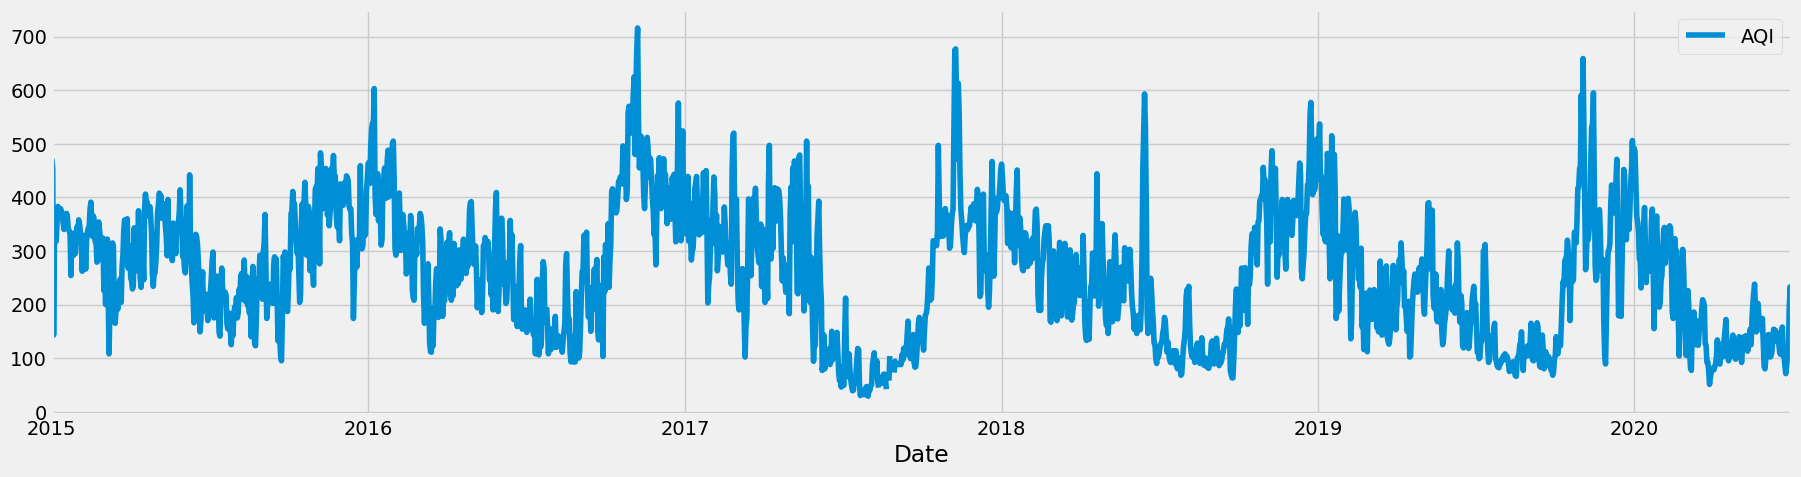

In [ ]:
# TO DO: Plotea los datos de la serie
plt.rcParams['figure.figsize'] = 20, 5
ts.plot()
plt.show()

## Missing values

In [ ]:
# TO DO: Check nulls y en que fechas hay nulls
ts.isna().sum()

AQI    10
dtype: int64

In [ ]:
ts[ts['AQI'].isna()]

,AQI
Date,
2016-07-24,NaN
2017-06-23,NaN
2017-08-13,NaN
2017-08-14,NaN
2017-08-22,NaN
2017-08-23,NaN
2017-08-26,NaN
2017-08-27,NaN
2017-08-28,NaN


Como hacer un modelo de series temporales diario suele ser complejo y poco eficaz, lo que haremos será agregar el dato en promedios mensuales, por lo que en este caso no sería necesario tratar los nulos ya que todos los meses tienen datos suficientes para obtener un promedio mensual.

Aun así, de modo didáctico, vamos a ver como corregiríamos estos nulos si fuera necesario:

In [ ]:
ts_nulls = ts['2017-08']

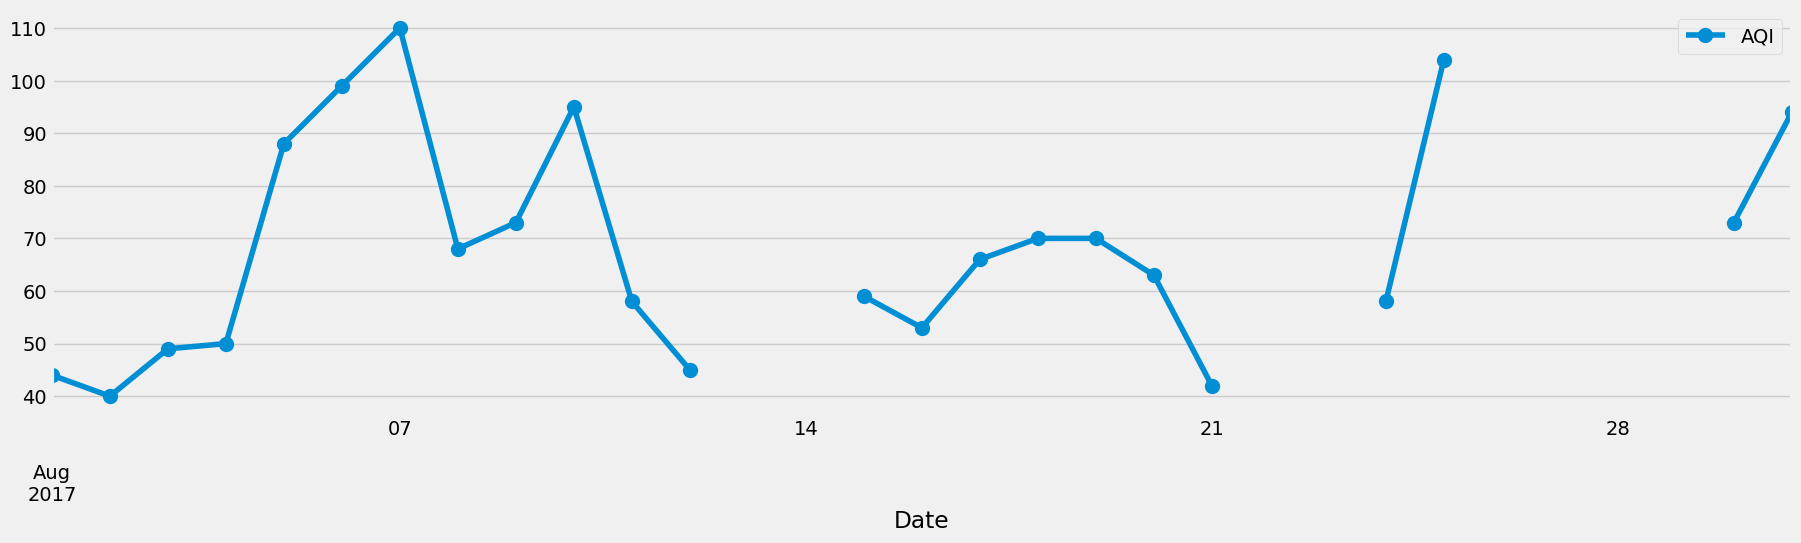

In [ ]:
ts_nulls.plot(marker='o', markersize=10)
plt.show()

In [ ]:
#Para pintar en las graficas los intervalos a tratar:
null_intervals =(('2017-08-12','2017-08-15'),
                 ('2017-08-21','2017-08-24'),
                ('2017-08-25','2017-08-30'))

* **Media**

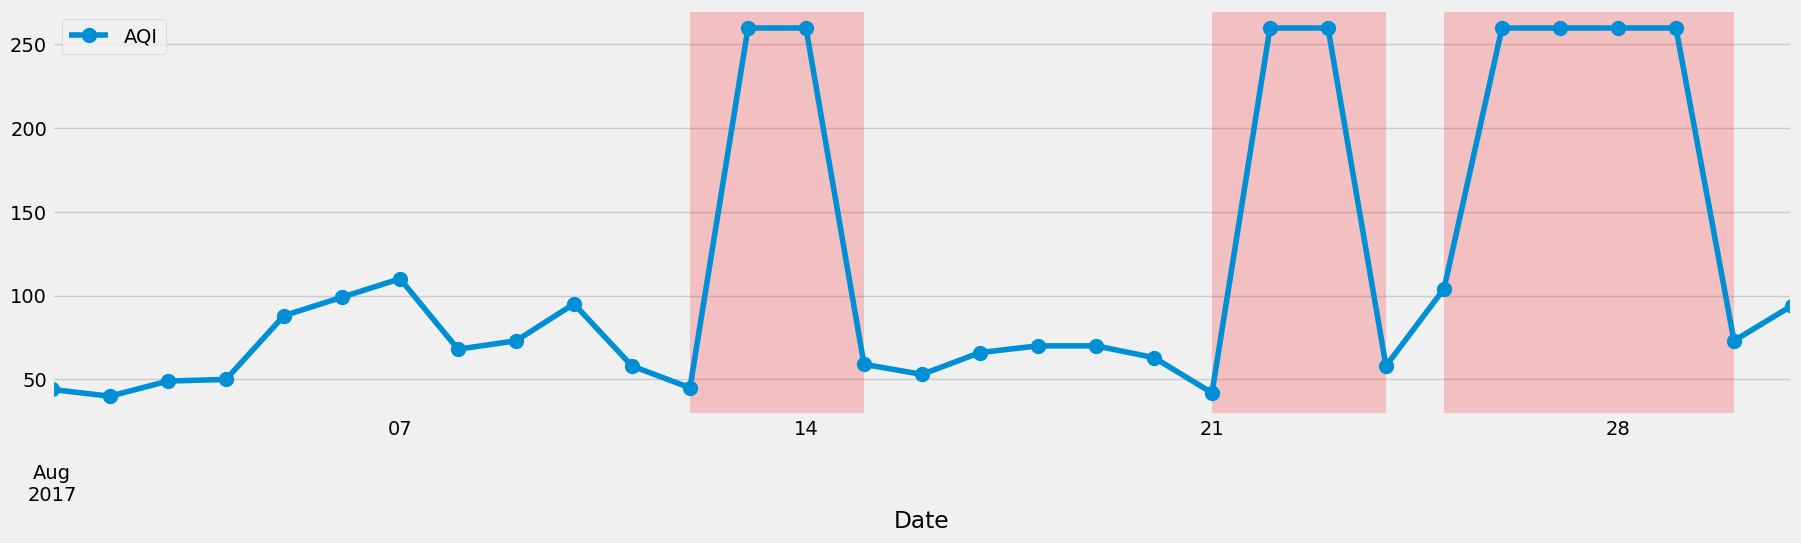

In [ ]:
ts_FillMean = ts_nulls.copy(deep=True)

ts_FillMean['AQI'] = ts_FillMean.fillna(ts.AQI.mean())  # Media de la serie entera

ax = ts_FillMean.plot(marker='o', markersize=10)
for a,b in null_intervals:
    ax.axvspan(a, b, facecolor='red', alpha=.2)
plt.show()

* **Media estacional (mensual)**

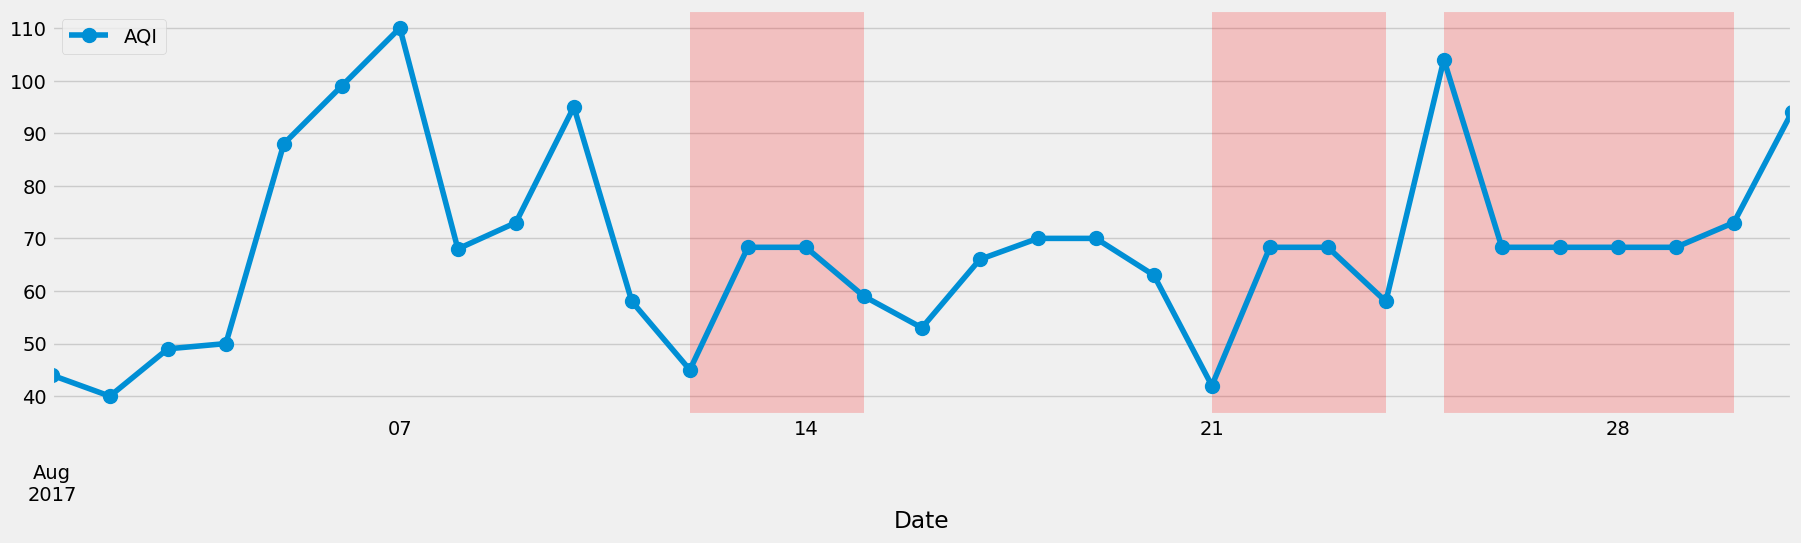

In [ ]:
#TO DO: Rellena los nulos con la media de Agosto 2017
ts_SM = ts_nulls.copy(deep=True)
ts_SM['AQI'] =  ts_SM.fillna(ts['2017-08'].AQI.mean())

ax = ts_SM.plot(marker='o', markersize=10)
for a,b in null_intervals:
    ax.axvspan(a, b, facecolor='red', alpha=.2)
plt.show()

* **Interpolación lineal**

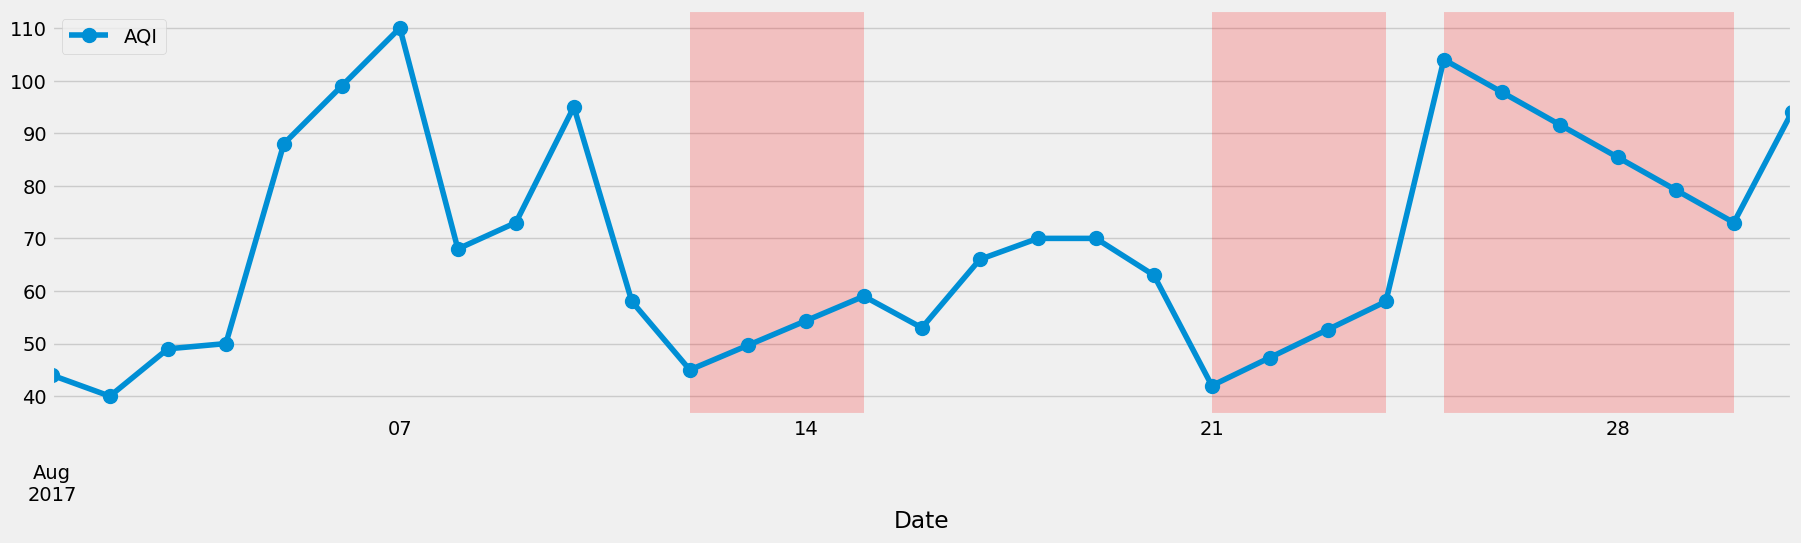

In [ ]:
ts_LI = ts_nulls.copy(deep=True)
#ts_LI['AQI'] = ts_LI.AQI.interpolate(method='linear')
ts_LI['AQI'] = ts_LI['AQI'].interpolate(method='linear')

ax = ts_LI.plot(marker='o', markersize=10)
for a,b in null_intervals:
    ax.axvspan(a, b, facecolor='red', alpha=.2)
plt.show()

* **Interpolacion Cuadratica**

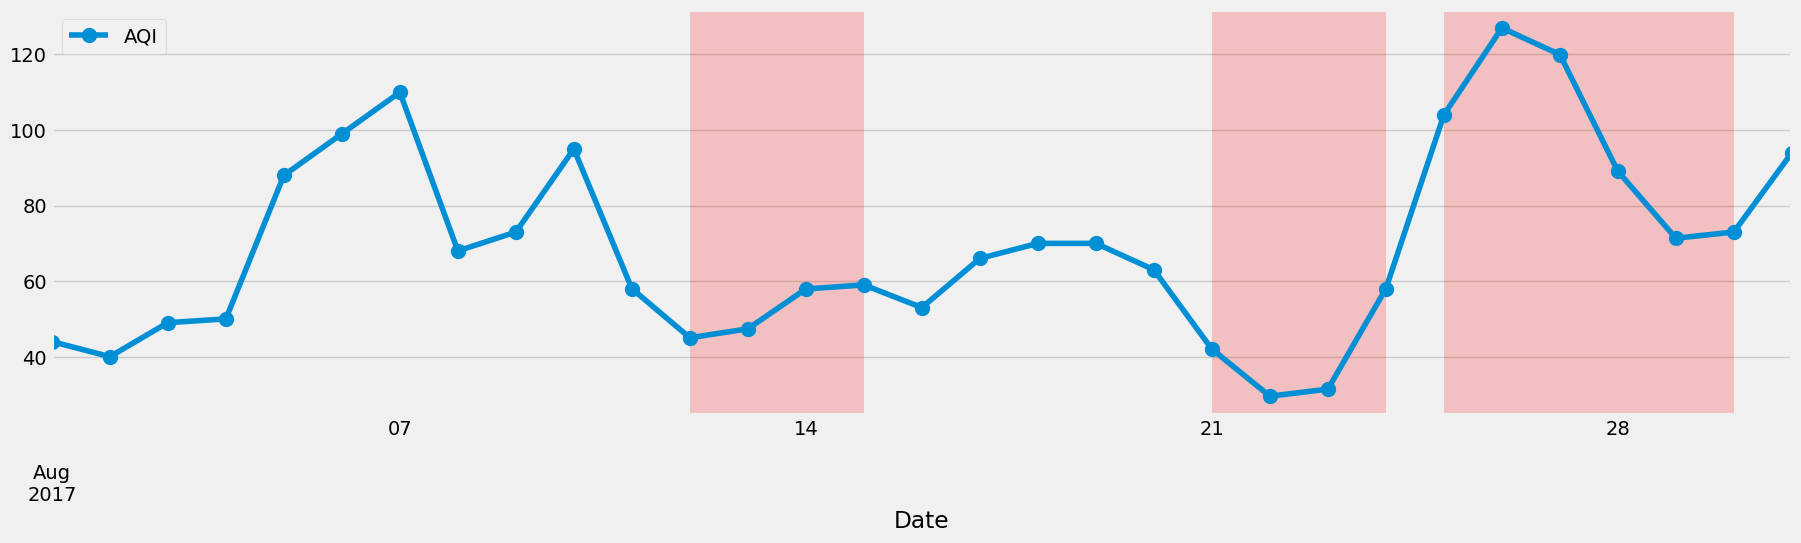

In [ ]:
ts_QI = ts_nulls.copy(deep=True)

ts_QI['AQI'] = ts_QI.AQI.interpolate(method='quadratic')

ax = ts_QI.plot(marker='o', markersize=10)
for a,b in null_intervals:
    ax.axvspan(a, b, facecolor='red', alpha=.2)
plt.show()

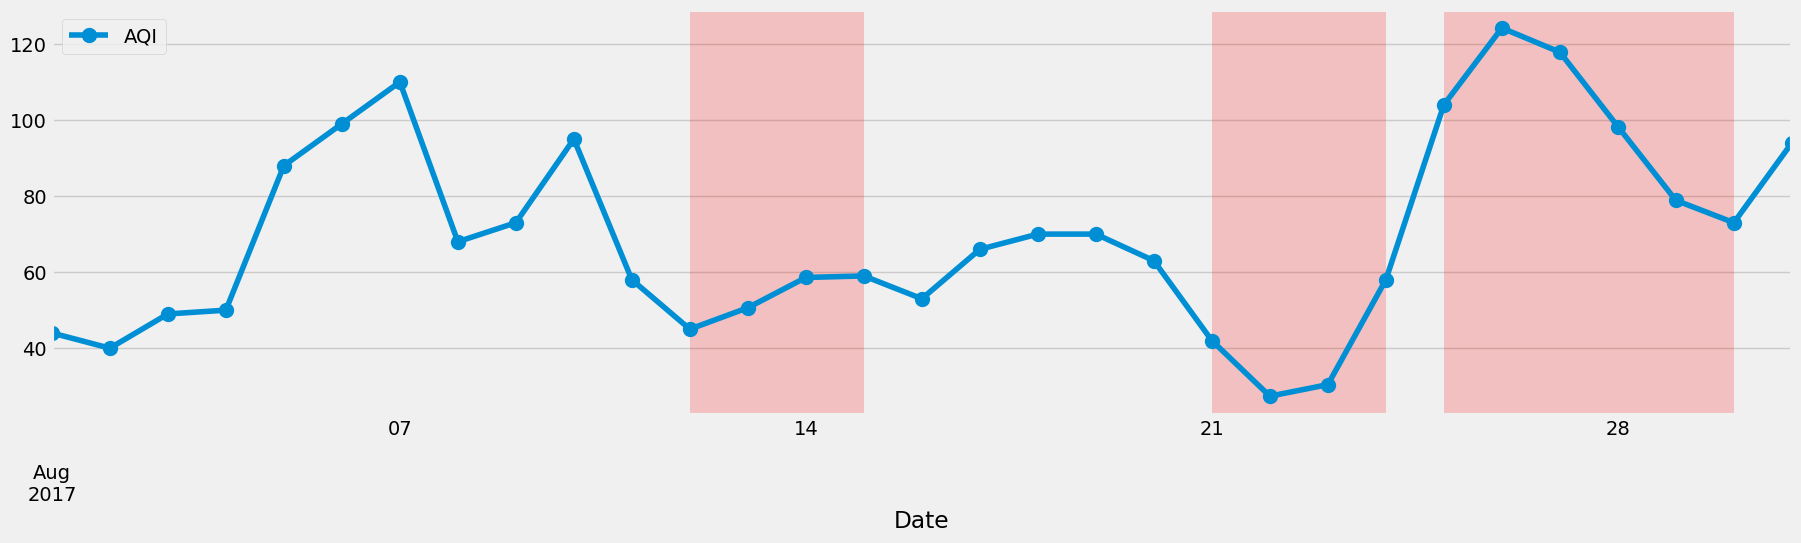

In [ ]:
ts_QI = ts_nulls.copy(deep=True)

ts_QI['AQI'] = ts_QI.AQI.interpolate(method='cubic')

ax = ts_QI.plot(marker='o', markersize=10)
for a,b in null_intervals:
    ax.axvspan(a, b, facecolor='red', alpha=.2)
plt.show()

## Resample

Como hemos visto, en este caso particular, optaremos por un resample: de dato diario a mensual. Con lo cual no tendremos problema de nulos.

In [ ]:
ts.head()

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0


In [ ]:
#TO DO: Haz un resampleo de dato diario a media mensual
ts_m = ts['AQI'].resample('MS').mean()  # Month Start
# Sacará el promedio de cada mes tomando como inicio el 1 de cada mes

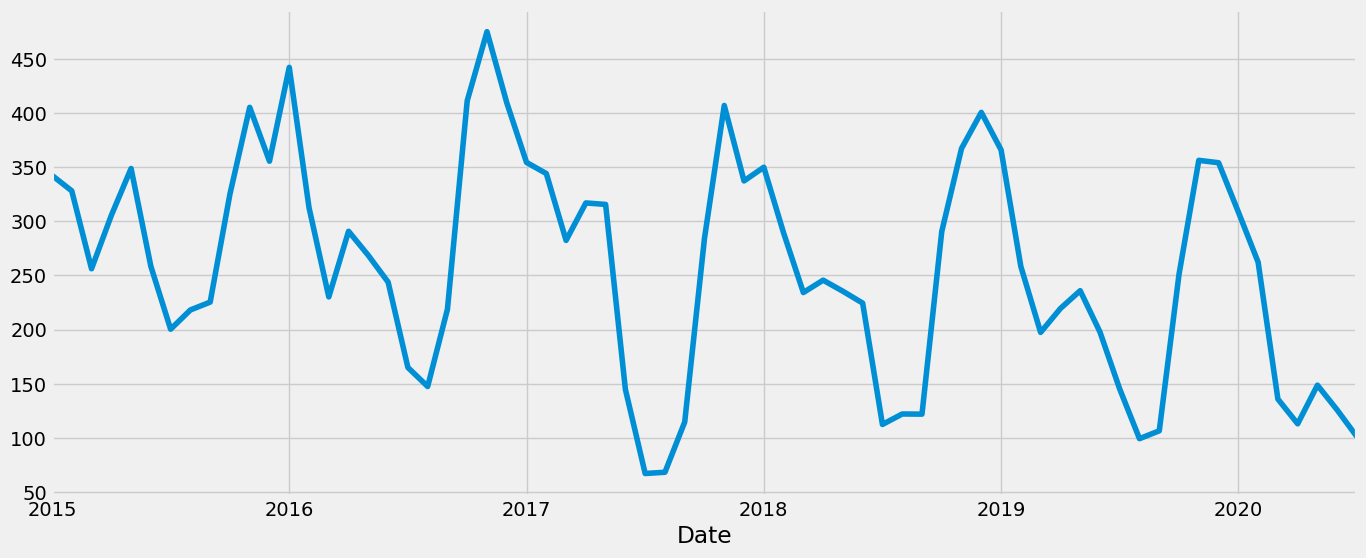

In [ ]:
ts_m.plot(figsize = (15, 6))
plt.show()

**CHECK!** Compara tus resultados con el resultado correcto antes de continuar:
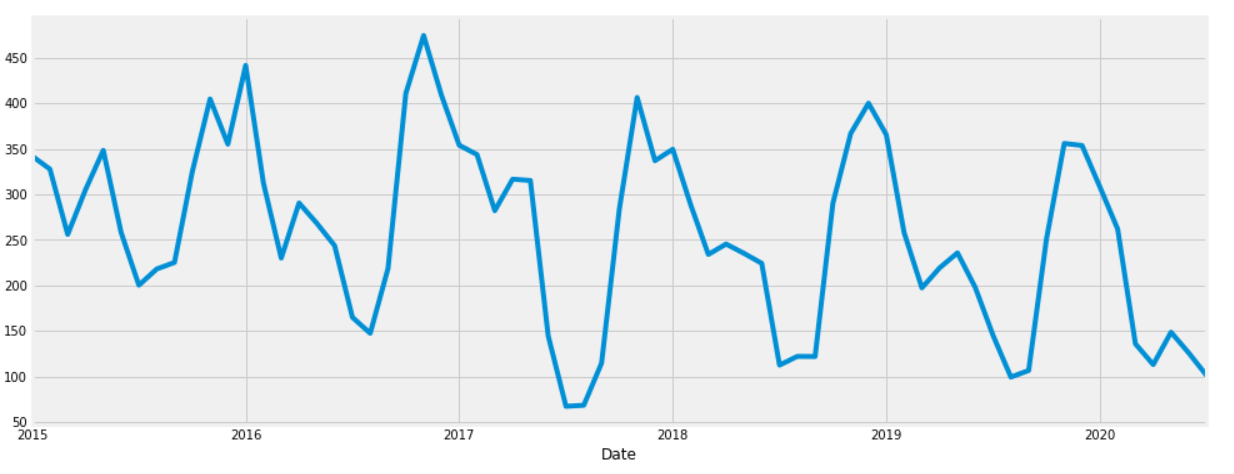

Pareciera ser que la calidad del aire va mejorando con cada año

# Descomposición estacional

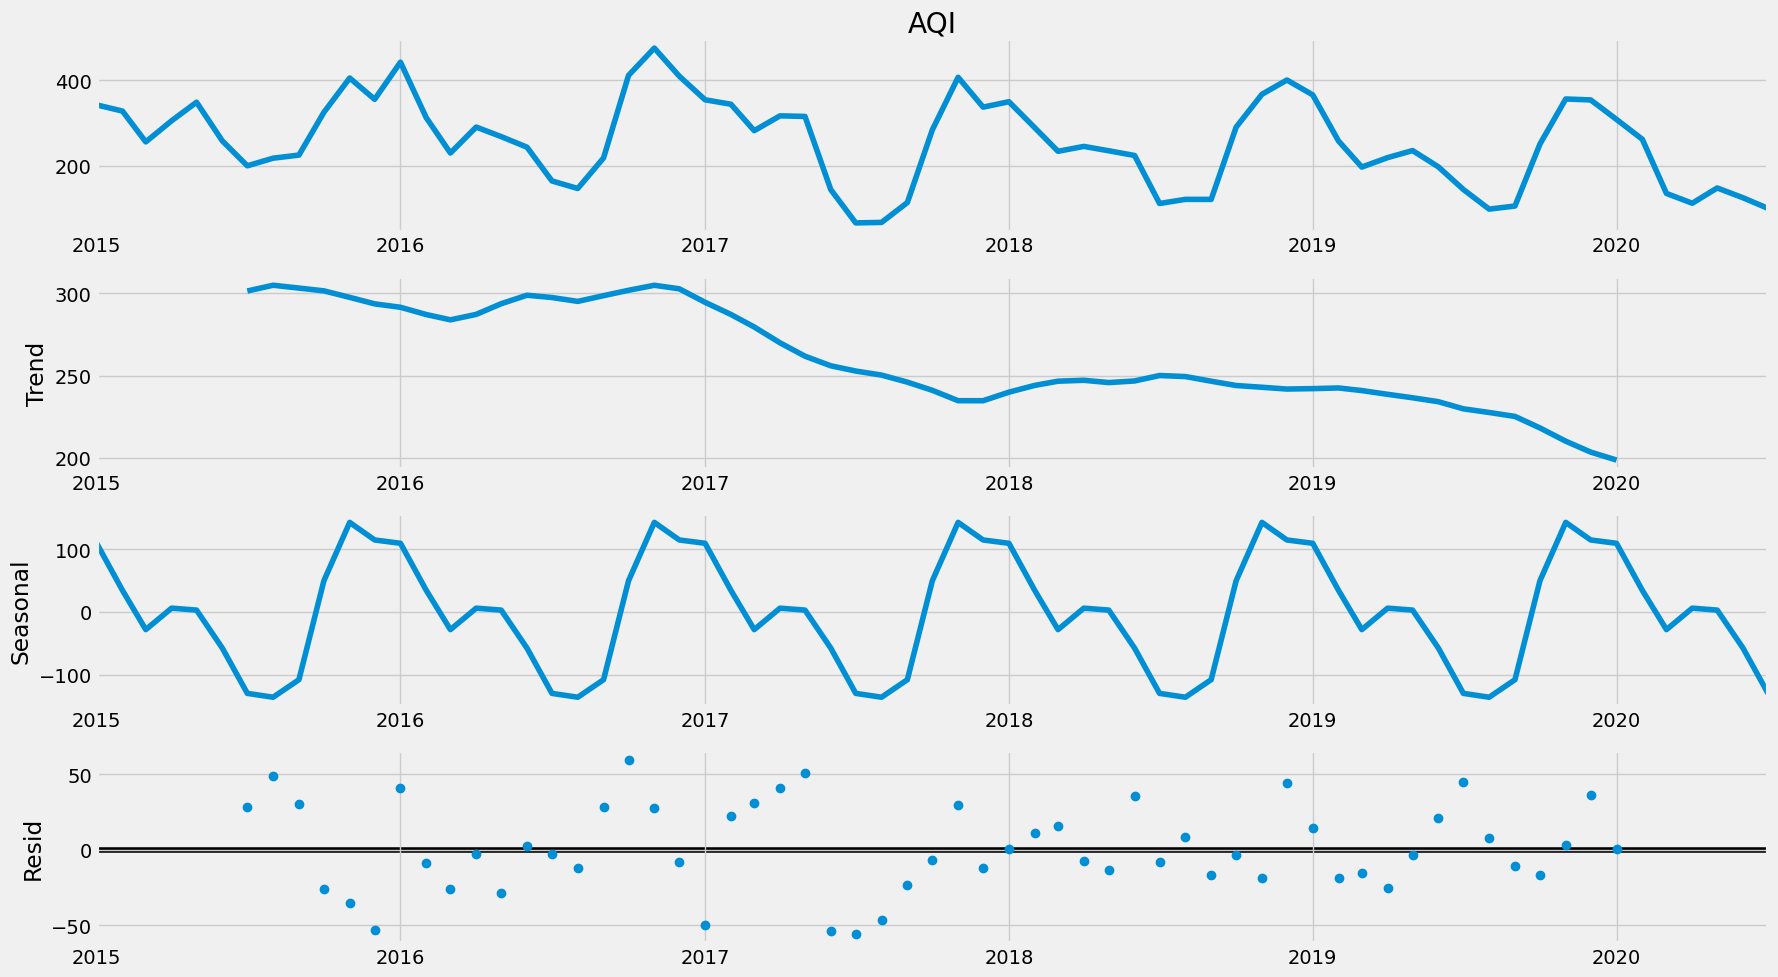

In [ ]:
plt.rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(ts_m, model='additive')
fig = decomposition.plot()
plt.show()
# 1 Original
# 2 Tendencia
# 3 Estacionalidad (Ciclos y estaciones) Existe una estacionalidad anual
# 4 Residual (en modelo aditivo)

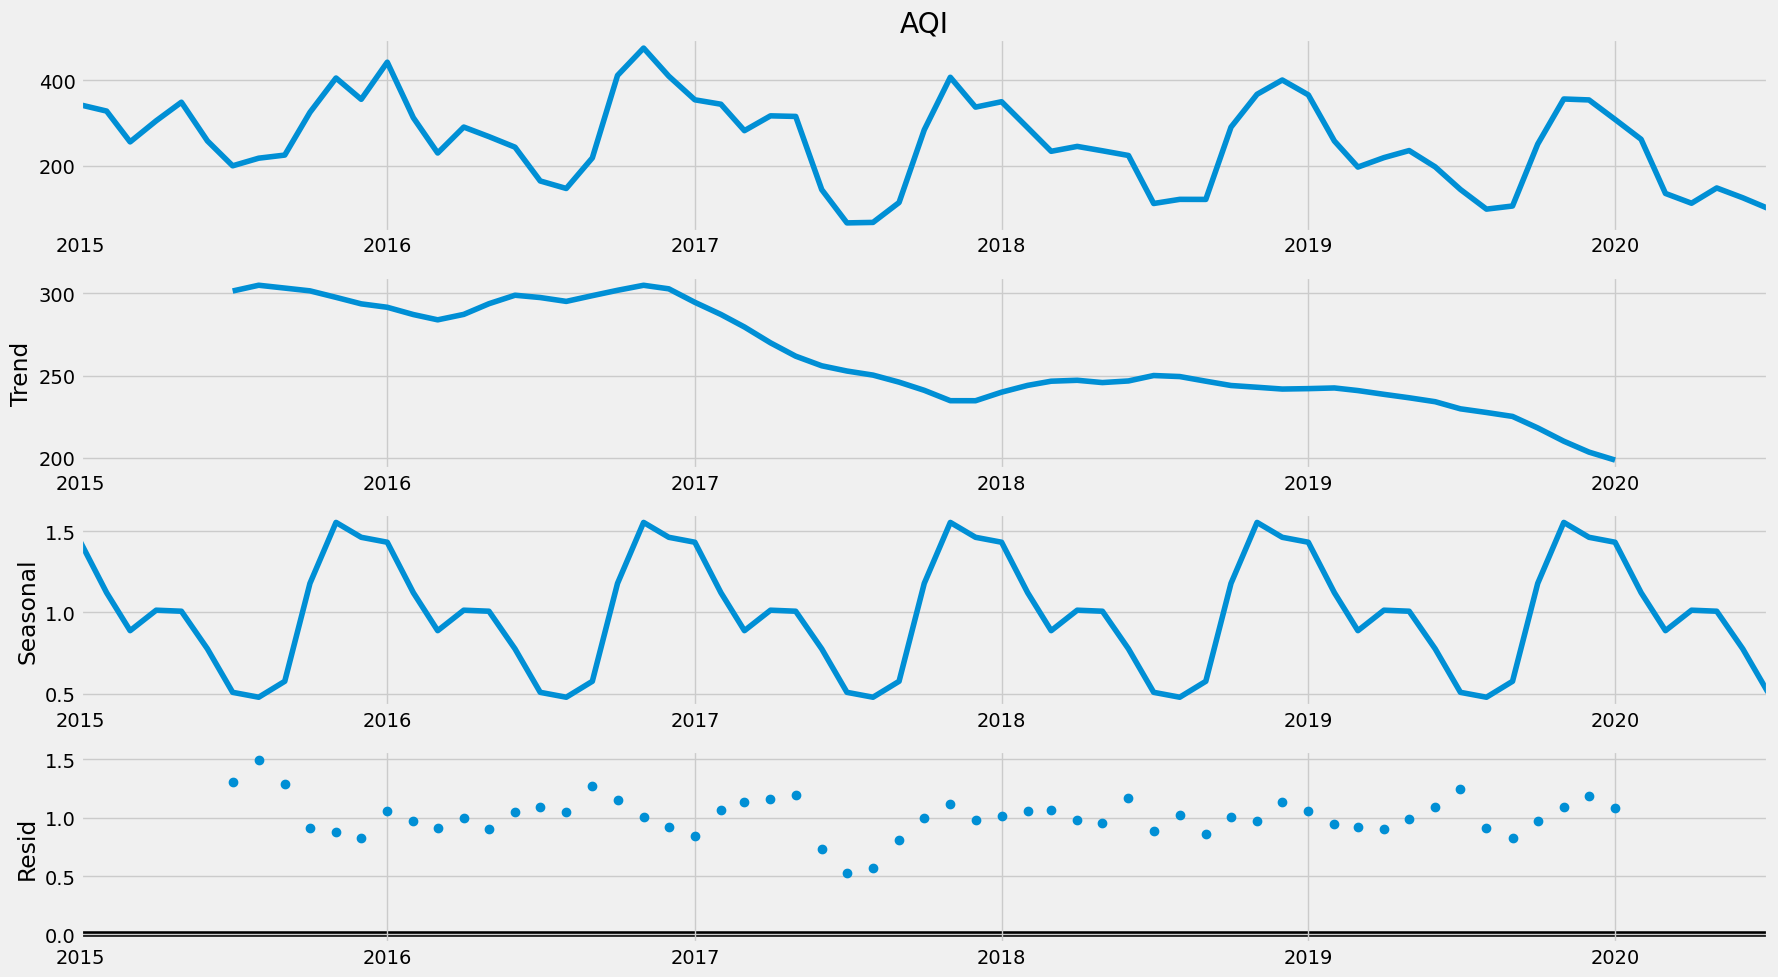

In [ ]:
plt.rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(ts_m, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [ ]:
#TO DO: Completa el siguiente análisis

Analizando la descomposición observamos:
* La tendencia (trend) es decreciente
* La estacionalidad es anual con [12] lags

# Split train test

Para comparar resultados de modelos vamos a utilizar el mismo train-test set

In [ ]:
test_ratio = 0.2
test_size = int(len(ts_m)*test_ratio)  # Como no tenemos tanto histórico elegimos el 20%
test_size  # Es un ciclo

13

In [ ]:
train = ts_m[:-test_size]  # -13 contando desde abajo de tal manera que mis ultimas 13 observaciones sean para el test
test = ts_m[-test_size:]

In [ ]:
test.index.min(), test.index.max()

(Timestamp('2019-07-01 00:00:00', freq='MS'),
 Timestamp('2020-07-01 00:00:00', freq='MS'))

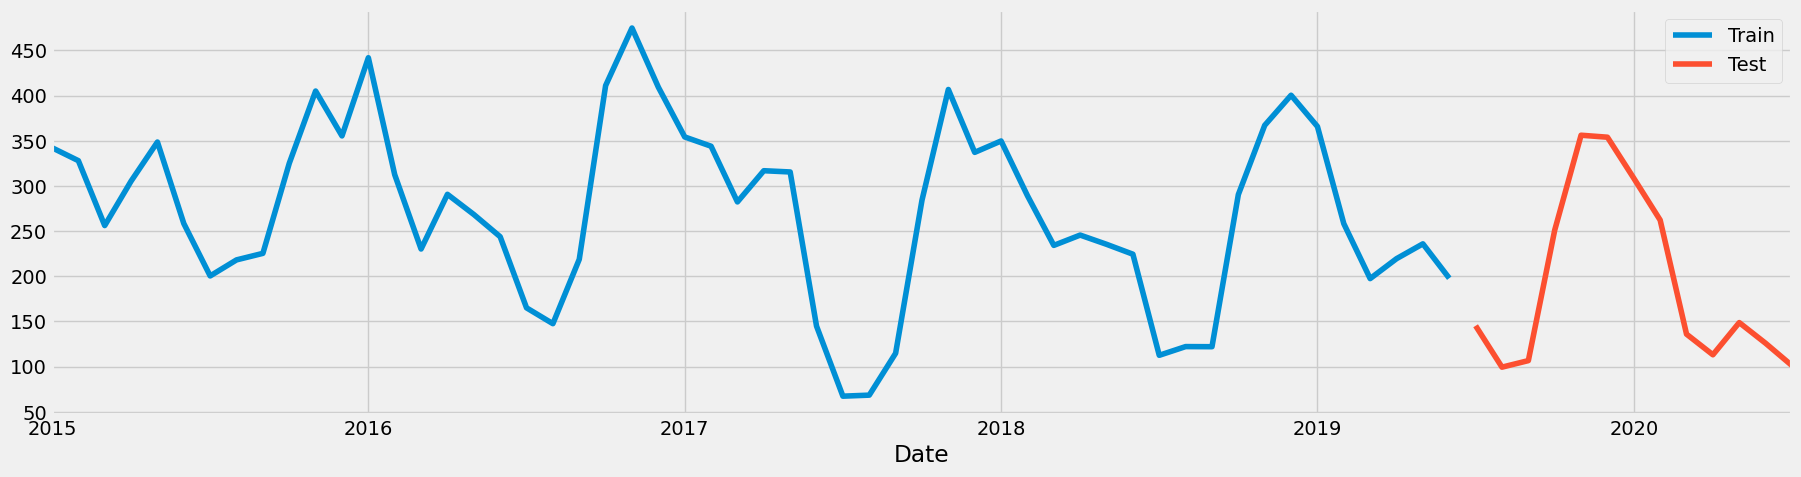

In [ ]:
plt.rcParams['figure.figsize'] = 20, 5
train.plot()
test.plot()
plt.legend(['Train','Test'])
plt.show()

# SARIMA

## Test stationarity

**NOTA:** En lugar de utilizar el training set para el análisis de estacionariedad y autocorrelaciones vamos a utilizar toda la serie (train+test). Recordar que el análisis de la estacionariedad y autocorrelaciones no forma parte del entrenamiento, se trata de un análisis previo que nos ayuda a aproximar la mejor configuración con la que entrenar el modelo ARIMA.

In [ ]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')   # statsmodels.tsa.stattools
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])  # Nos quedamos con las primeras 4 métricas dftest[0:4]
    print (dfoutput)

print(adf_test(ts_m))

Results of Dickey-Fuller Test:
Test Statistic                  0.229024
p-value                         0.973843
#Lags Used                     11.000000
Number of Observations Used    55.000000
dtype: float64
None


El test determina que NO ES ESTACIONARIA (p-value>0.05). Procedemos a intentar solucionarlo aplicando diferenciación, aplicamos **primero diferenciación de primer orden** (first differences) (yt - yt-1):

In [ ]:
train[:10]

Date
2015-01-01    342.290323
2015-02-01    327.928571
2015-03-01    256.064516
2015-04-01    305.266667
2015-05-01    348.580645
2015-06-01    258.333333
2015-07-01    200.290323
2015-08-01    218.064516
2015-09-01    225.300000
2015-10-01    325.000000
Freq: MS, Name: AQI, dtype: float64

In [ ]:
train[:10].shift(1) # El argumento que pongamos dentro de shift será el número de nulos agregados en la parte de arriba

Date
2015-01-01           NaN
2015-02-01    342.290323
2015-03-01    327.928571
2015-04-01    256.064516
2015-05-01    305.266667
2015-06-01    348.580645
2015-07-01    258.333333
2015-08-01    200.290323
2015-09-01    218.064516
2015-10-01    225.300000
Freq: MS, Name: AQI, dtype: float64

In [ ]:
#TO DO: Aplica diferenciacion de primer orden utilizando la funcion shift()
ts_diff1 = train - train.shift(1)

In [ ]:
ts_diff1.dropna(inplace=True)   #Elimina nulos producto del shift

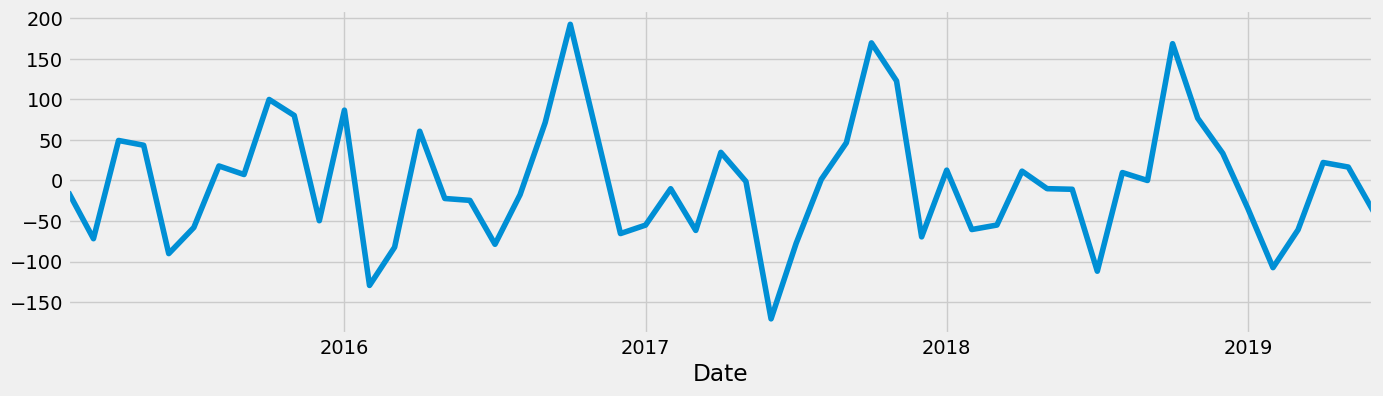

In [ ]:
ts_diff1.plot(figsize = (15, 4))
plt.show()

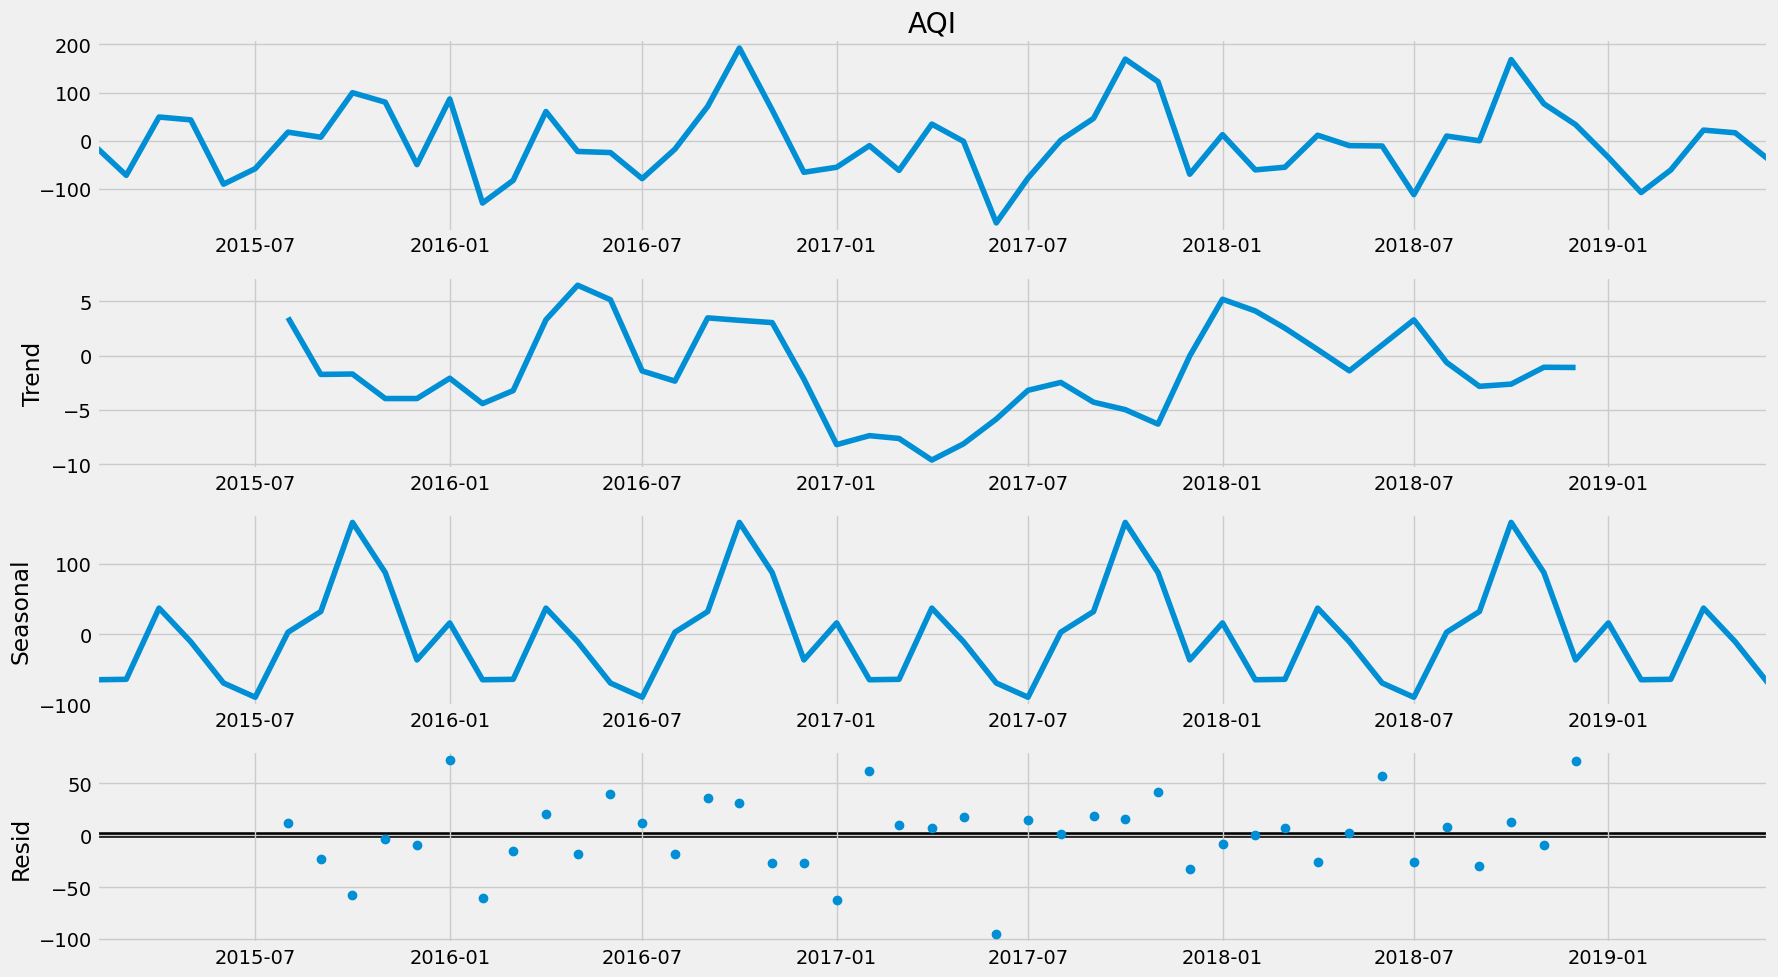

In [ ]:
plt.rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(ts_diff1, model='additive')
fig = decomposition.plot()
plt.show()

# En este caso la tendencia eliminamos la variación de la media para que sea un poco más estacionaria

In [ ]:
#TO DO: Aplica el ADF Test sobre la nueva serie transformada
print(adf_test(ts_diff1))

Results of Dickey-Fuller Test:
Test Statistic                -5.661976e+00
p-value                        9.334924e-07
#Lags Used                     1.000000e+01
Number of Observations Used    4.200000e+01
dtype: float64
None


**CHECK!** p-value = 9.334924e-07

Vemos que con una diferenciación de primer orden la tendencia desaparece y la serie se vuelve  **ESTACIONARIA** (p<0.05). <br>Podemos estimar que el parametro d del modelo ARIMA será **d=1**. <br><br> Como se trata de una serie estacional (**s=12**), aplicamos tambien diferenciacion estacional (y-yt-12), lo cual nos ayudará a paliar el efecto de la estacionalidad en el análisis de autocorrelaciones. Como la serie ya es estacionaria, con una diferenciación estacional de primer orden (**D=1**) debería ser suficiente:

In [ ]:
#TO DO: Aplica diferenciación estacional utilizando la funcion shift()
ts_diff12 = ts_diff1 - ts_diff1.shift(12)

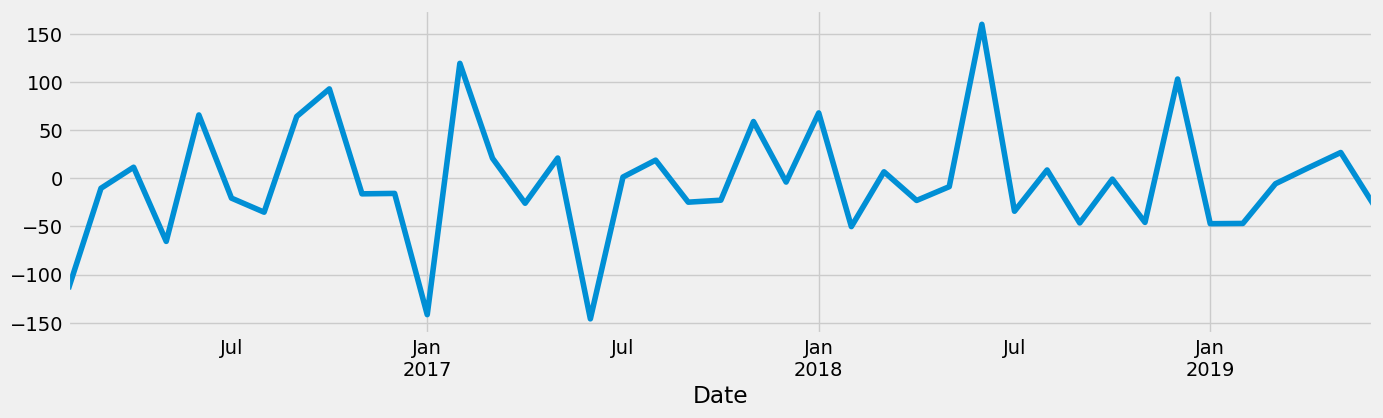

Results of Dickey-Fuller Test:
Test Statistic                 -5.307593
p-value                         0.000005
#Lags Used                      3.000000
Number of Observations Used    37.000000
dtype: float64
None


In [ ]:
ts_diff12.dropna(inplace=True)   #Elimina nulos producto del shift
ts_diff12.plot(figsize = (15, 4))
plt.show()
print(adf_test(ts_diff12))

**CHECK!** p-value = 0.000005

DONE! Ahora que hemos eliminado el efecto de la estacionalidad nuestra serie SÍ ES ESTACIONARIA (p-value<0.05).

## Análisis Autocorrelaciones (ACF y PACF)

In [ ]:
# TO DO: Determina los parametros p,q del modelo ARIMA a partir de la lectura de los correlogramas PACF y ACF para los primeros 12 lags

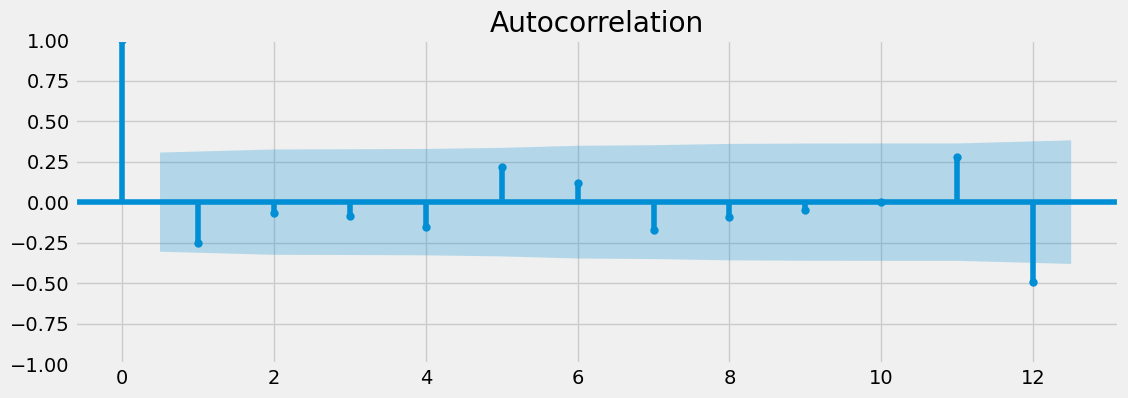

In [ ]:
plt.rcParams['figure.figsize'] = 12, 4
plot_acf(ts_diff12,lags=12)
plt.show()

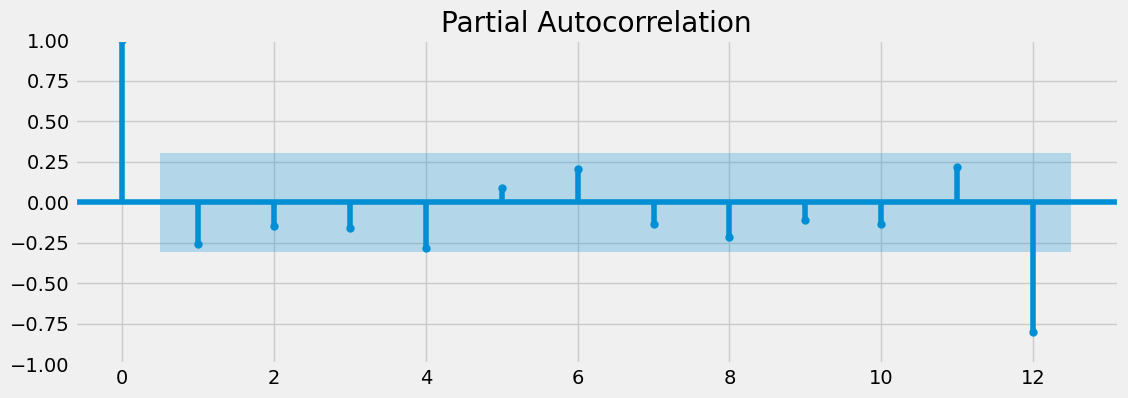

In [ ]:
plot_pacf(ts_diff12, lags=12)
plt.show()

Como hemos hecho la separación entre el training y el test parece ser que con el train el análisis de autocorrelaciones no detecta lags significativos. mientras que utilizando toda la serie entera si te los detecta

# Análisis Autocorrelaciones (ACF y PACF) Datos train y test

In [ ]:
diff = ts_m.diff().diff(24)
diff.dropna(inplace=True)

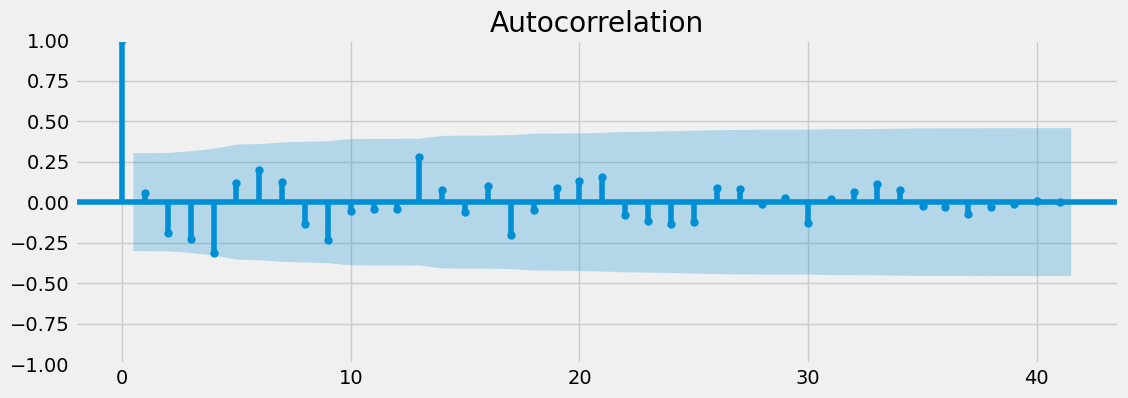

In [ ]:
# q= 3 y 4
# Q = 1
plt.rcParams['figure.figsize'] = 12, 4
plot_acf(diff,lags=41)
plt.show()

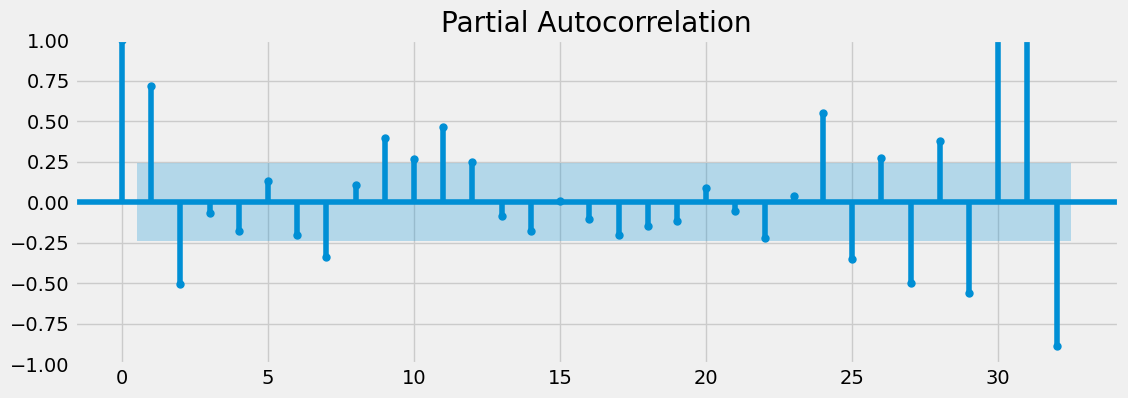

In [ ]:
#p= 1, 2
plot_pacf(ts_m,lags=32)
plt.show()

Analizando los correlogramas podemos acotar los parámetros del modelo ARIMA:


*   El PACF muestra autocorrelación significativa en el lag -1 por lo que podemos estimar **p=1**
*   El ACF muestra autocorrelación significativa en el lag -1 por lo que podemos estimar **q=1**








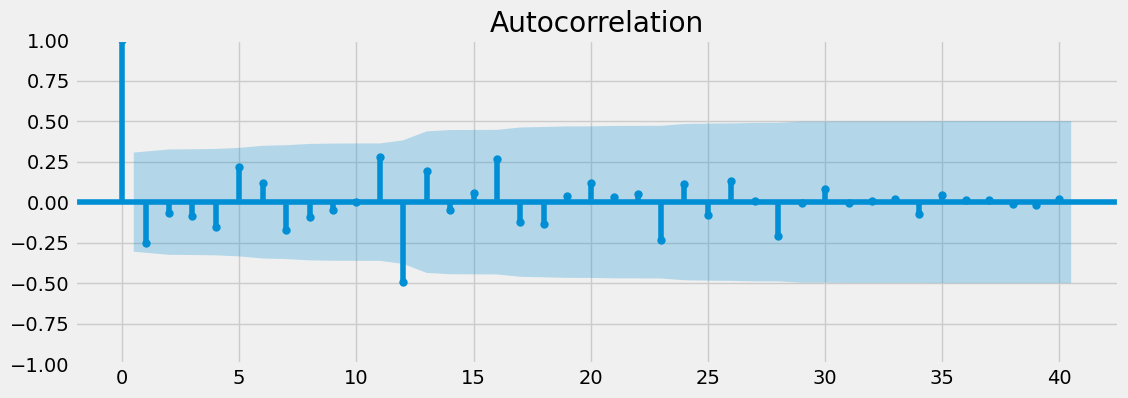

In [ ]:
# TO DO: Determina los parametros P,D,Q del modelo SARIMA a partir de la interpretacion de los diagramas PACF y ACF para los primeros 48 lags
plt.rcParams['figure.figsize'] = 12, 4
plot_acf(ts_diff12,lags=40)
plt.show()

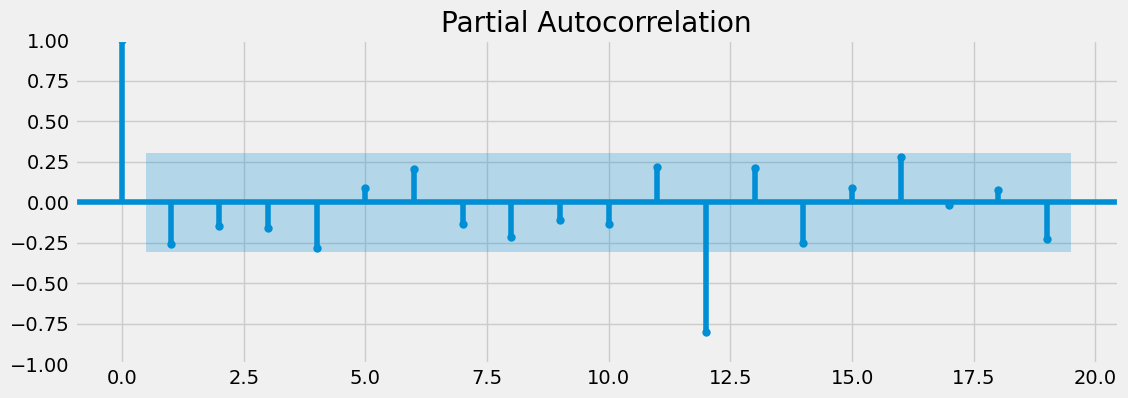

In [ ]:
plot_pacf(ts_diff12, lags=19)
plt.show()

*   El PACF muestra autocorrelación significativa en el lag estacional 12 por lo que podemos estimar el componente estacional **P=1**
*   El ACF muestra autocorrelación significativa en el lag estacional 12 por lo que podemos estimar el componente estacional **Q=1**

Por otra parte, como hemos visto anteriormente:
* La estacionalidad (seasonality) es de 12 lags, **s=12**.
* Como la serie temporal original no es estacionaria es necesario aplicar diferenciacion de primer orden, **d=1**.
* Como la serie tiene un comportamiento claramente estacional, es necesario aplicar diferenciacion estacional de primer orden **D=1**.


<br>De manera que nuestro modelo A PRIORI podría ser un **SARIMA: (1,1,1) x (1,1,1,12)**
<br><br>Esto no es más que una aproximación que nos ayuda a acotar el problema a la hora de lanzar un grid search que pruebe distintas configuraciones SARIMA. Para ello contamos con una holgura de +-1 en la seleccion de cada parámetro...

## Optimize SARIMA

In [ ]:
# TO DO: determina el rango de valores a iterar para los parametros p, q, P y Q. Reminder: range(0,3) incluye los valores 0, 1 y 2.
p = range(0,3)
d = 1
q = (0,3,4)
P = range(0,3)
D = 1
Q = range(0,3)
s = 24

# creating list with all the possible combinations of parameters
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

81

In [ ]:
def optimizeSARIMA(serie,parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(serie, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(train,parameters_list, d, D, s)

  0%|          | 0/81 [00:00<?, ?it/s]

CPU times: user 7min 48s, sys: 3min 35s, total: 11min 24s
Wall time: 7min


In [ ]:
#Min AIC. Los parametros mostrados son (p,q,P,Q)
result_table.head(1)

,parameters,aic
0,"(0, 3, 0, 0)",310.788074


El modelo óptimo resulta: **SARIMA (0,1,3)x(0,1,0,12)**

## Evaluación del modelo

In [ ]:
#TO DO: Entrena el modelo con la configuracion obtenida en el punto anterior
p=0
d=1
q=3
P=0
D=1
Q=0
s=12

model=sm.tsa.statespace.SARIMAX(train, order=(p,d,q),
                                        seasonal_order=(P,D,Q,s)).fit(disp=-1)

In [ ]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 AQI   No. Observations:                   54
Model:             SARIMAX(0, 1, 3)x(0, 1, [], 12)   Log Likelihood                -222.549
Date:                             Wed, 31 May 2023   AIC                            453.098
Time:                                     23:04:38   BIC                            459.952
Sample:                                 01-01-2015   HQIC                           455.594
                                      - 06-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5944      7.275     -0.082      0.935     -14.853      13.664
ma.L2         -0.1075      

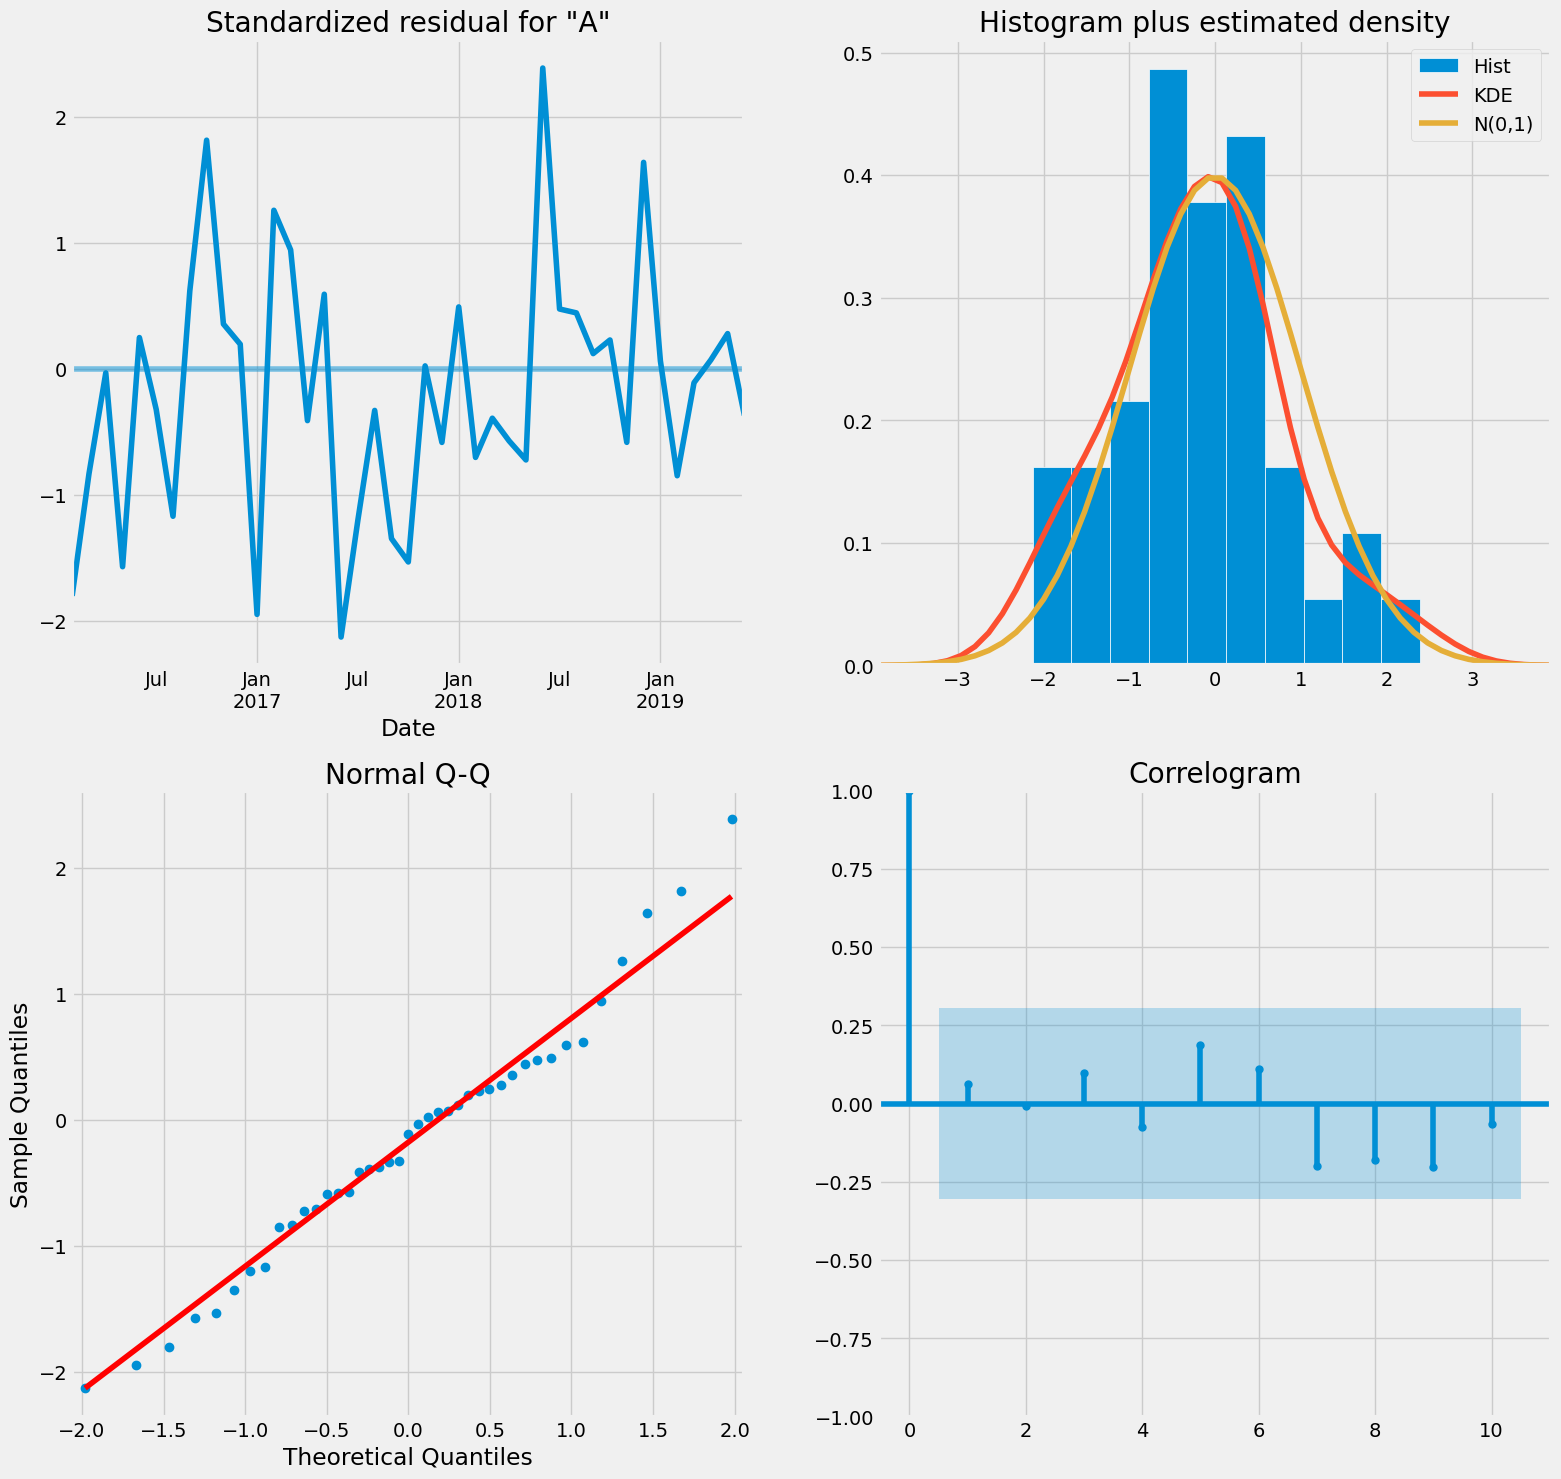

In [ ]:
model.plot_diagnostics(figsize=(17, 17))
plt.show()

In [ ]:
p=0
d=1
q=0
P=2
D=1
Q=1
s=12

model1=sm.tsa.statespace.SARIMAX(train, order=(p,d,q),
                                        seasonal_order=(P,D,Q,s)).fit(disp=-1)

In [ ]:
print(model1.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  AQI   No. Observations:                   54
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 12)   Log Likelihood                -216.120
Date:                              Wed, 31 May 2023   AIC                            440.240
Time:                                      23:04:49   BIC                            447.095
Sample:                                  01-01-2015   HQIC                           442.736
                                       - 06-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4824      1.421     -0.339      0.734      -3.268       2.304
ar.S.L24      -0.11

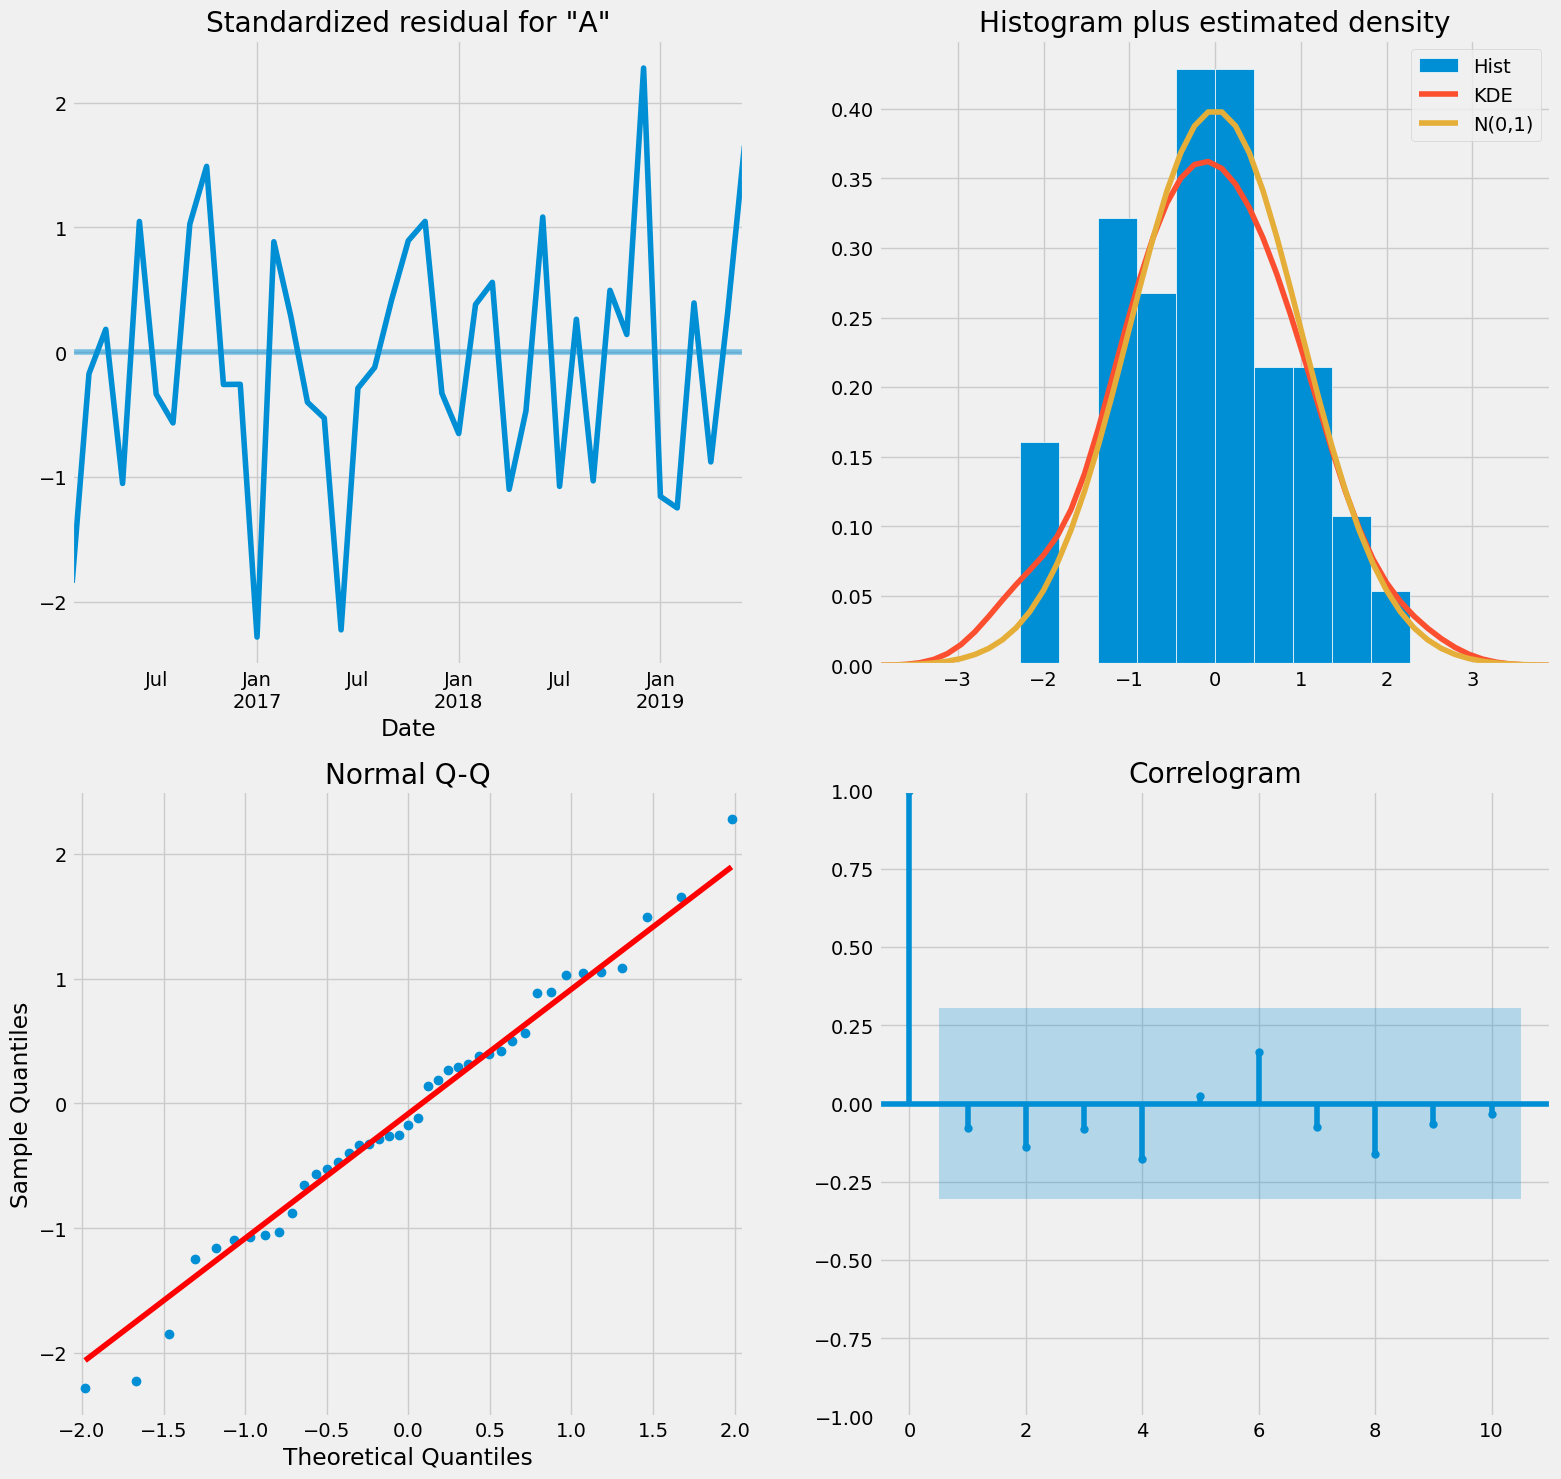

In [ ]:
model1.plot_diagnostics(figsize=(17, 17))
plt.show()

In [ ]:
# Definimos las metricas de evaluacion MAPE y RMSE:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [ ]:
def plotSARIMA(serie,model,s,d):
    pred = model.get_prediction(dynamic=False)
    pred_ci = pred.conf_int()[s+d:]
    ax = train.plot(label='observed')
    pred.predicted_mean[s+d:].plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('AQI')
    ax.set_title('MAPE train: '+str(round(MAPE(serie[s+d:],pred.predicted_mean[s+d:]),2))+'%')
    plt.legend()
    plt.show()

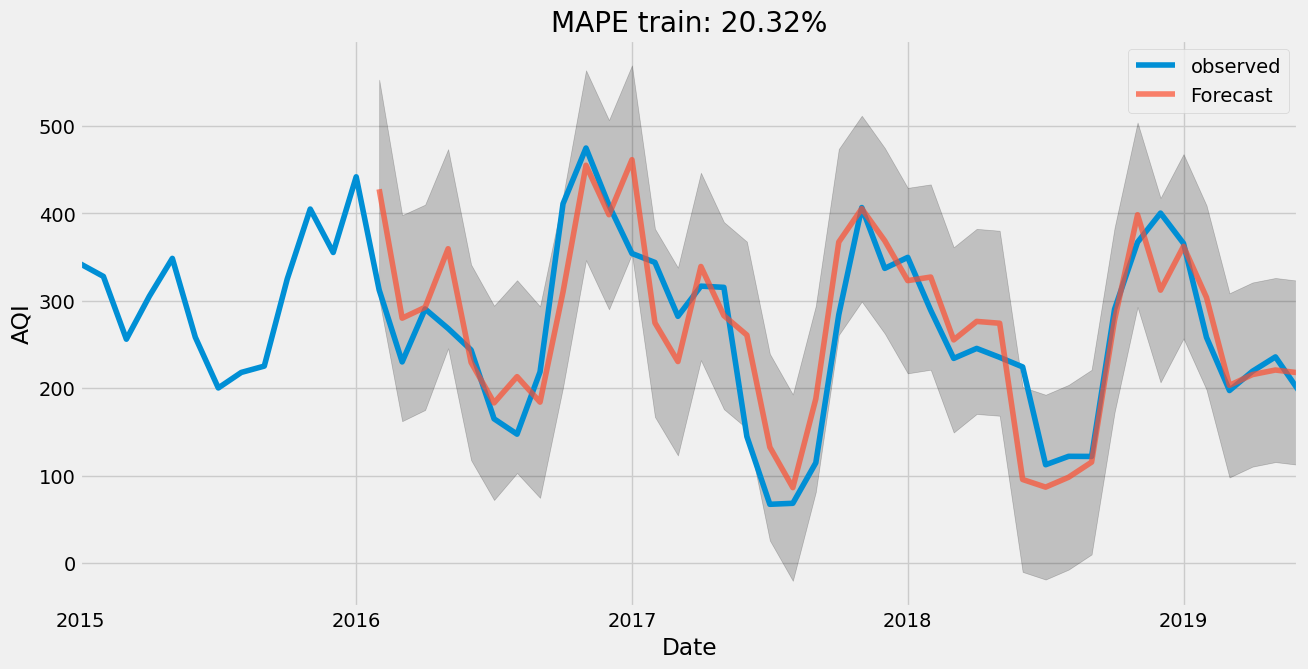

In [ ]:
plt.rcParams['figure.figsize'] = 20, 5
plotSARIMA(train,model,12,1)

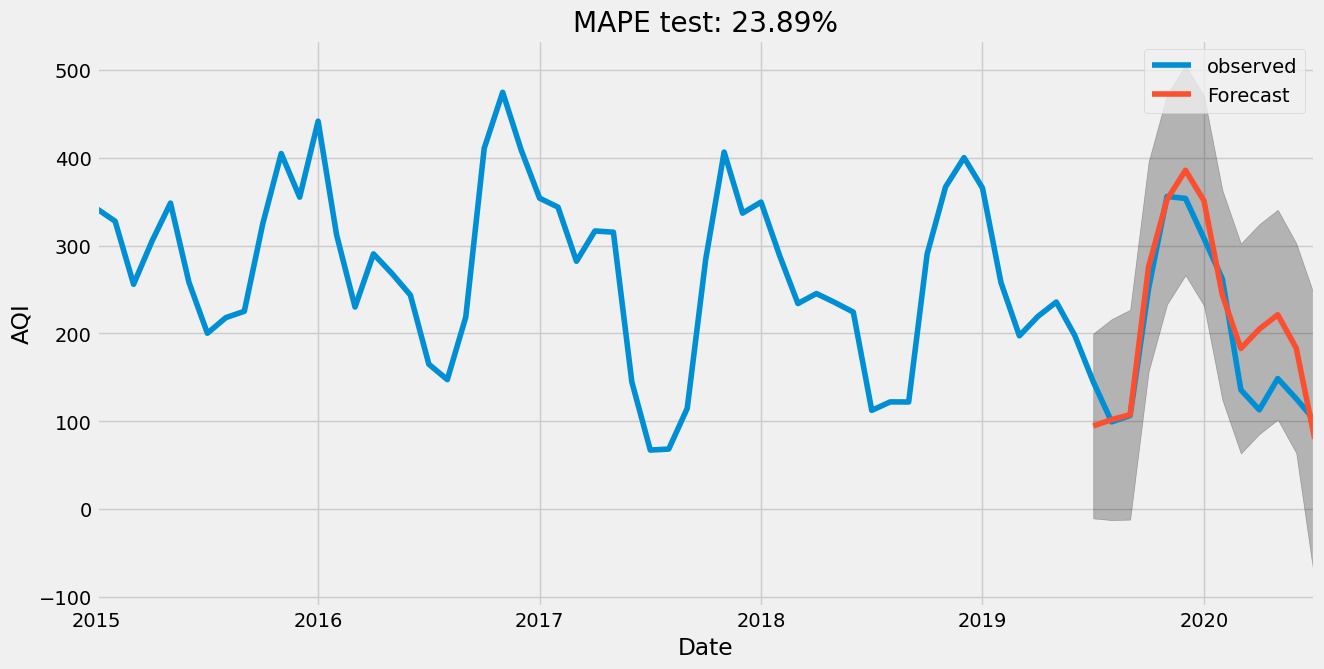

In [ ]:
plt.rcParams['figure.figsize'] = 20, 5
pred_uc = model.get_forecast(steps=test_size)
pred_ci = pred_uc.conf_int()
ax = ts_m.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
ax.set_title('MAPE test: '+str(round(MAPE(test,pred_uc.predicted_mean),2))+'%')
plt.legend()
plt.show()

In [ ]:
#RMSE
print('RMSE test:',round(RMSE(test,pred_uc.predicted_mean),2))

RMSE test: 44.82


## Forecast

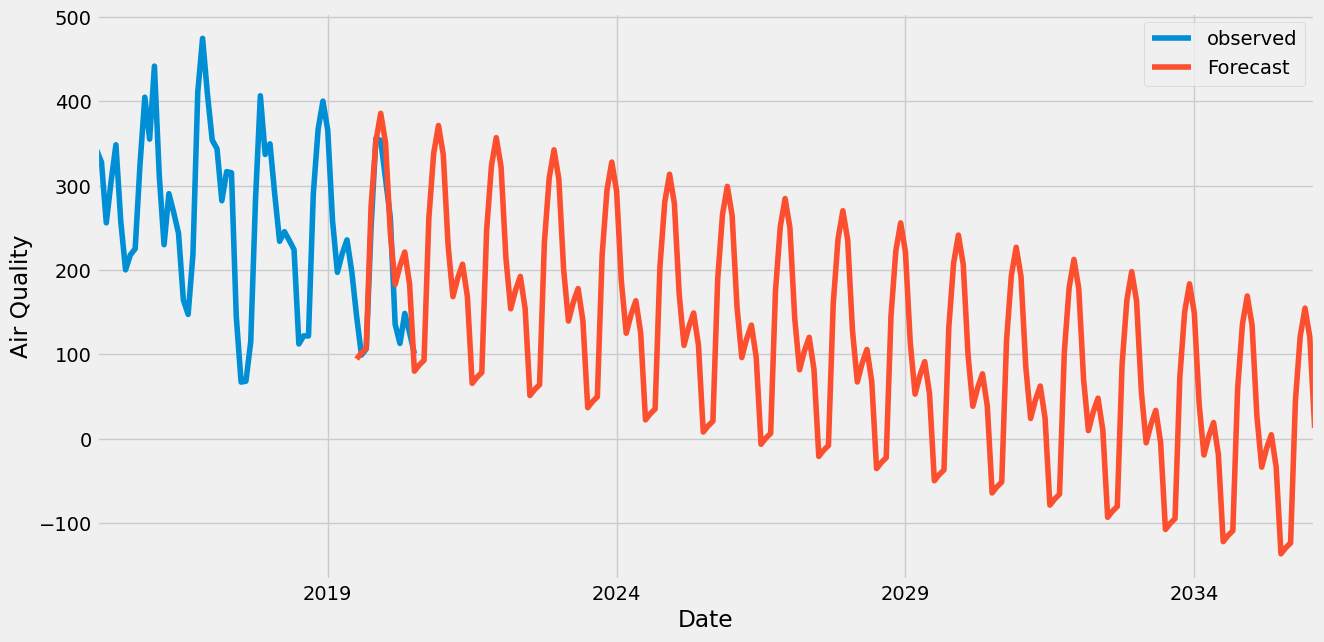

In [ ]:
pred_uc = model.get_forecast(steps=200)
pred_ci = pred_uc.conf_int()
ax = ts_m.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
#ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Air Quality')
plt.legend()
plt.show()

# FB Prophet

## Train

In [ ]:
train_prophet = pd.DataFrame(train)

In [ ]:
train_prophet.reset_index(inplace=True)

In [ ]:
# TO DO: Cambia el nombre de laS columnas de la serie. Debe ser el siguiente: 'ds' (fecha) - 'y' (valor)
train_prophet = train_prophet.rename(columns={'Date':'ds','AQI':'y'})

In [ ]:
train_prophet.head()

,ds,y
0,2015-01-01,342.290323
1,2015-02-01,327.928571
2,2015-03-01,256.064516
3,2015-04-01,305.266667
4,2015-05-01,348.580645


In [ ]:
#Train
# yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, holidays=None,
m = Prophet(seasonality_mode='additive')
m.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6xs_0gqr/b79sdxwt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6xs_0gqr/biuc2mmx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87073', 'data', 'file=/tmp/tmp6xs_0gqr/b79sdxwt.json', 'init=/tmp/tmp6xs_0gqr/biuc2mmx.json', 'output', 'file=/tmp/tmp6xs_0gqr/prophet_model72ykk99w/prophet_model-20230531230844.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:08:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Predict test data
future = m.make_future_dataframe(periods = test_size,freq = 'H')  #period: days you want to predict #freq monthly
forecast = m.predict(future)                     #dataframe with predicted data added

Text(0.5, 1.0, 'AQI')

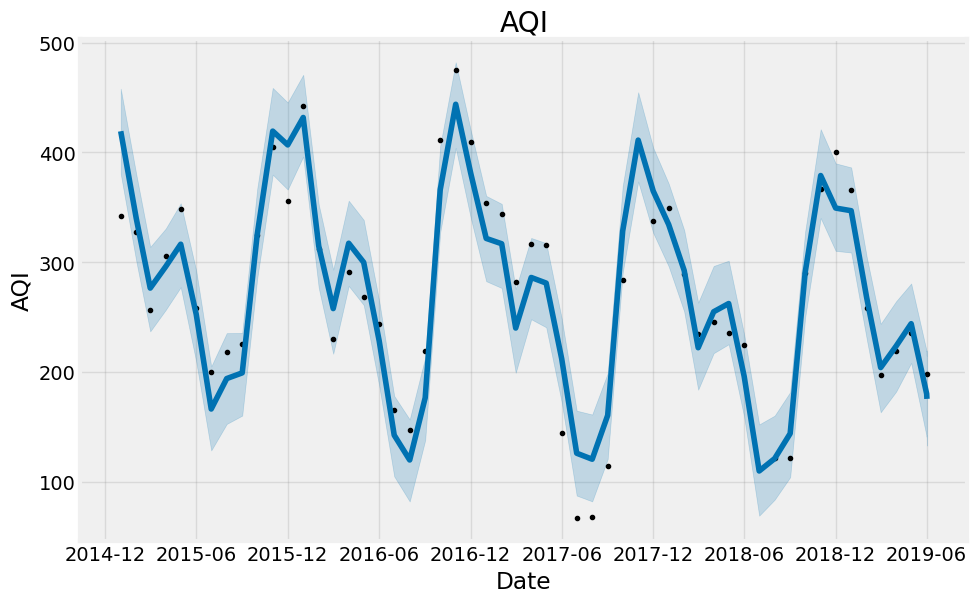

In [ ]:
#Plot results
m.plot(forecast, xlabel = 'Date', ylabel = 'AQI')
plt.title('AQI')
# Los puntos son los datos reales

## Evaluation

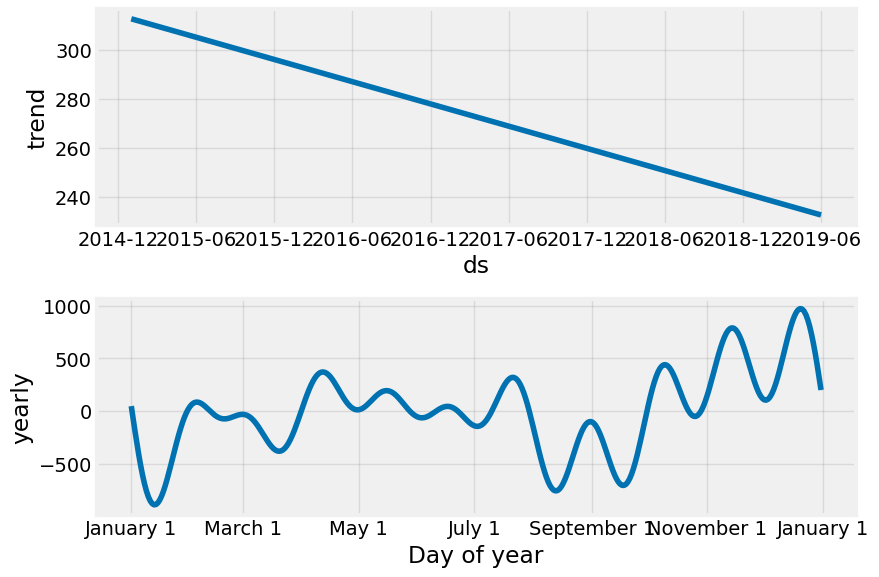

In [ ]:
m.plot_components(forecast)
plt.show()

In [ ]:
forecast.head(5)  #yhat son los niveles de confianza

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,312.561416,380.500213,458.034177,312.561416,312.561416,106.700477,106.700477,106.700477,106.700477,106.700477,106.700477,0.0,0.0,0.0,419.261892
1,2015-02-01,311.025540,301.223349,380.200357,311.025540,311.025540,29.013021,29.013021,29.013021,29.013021,29.013021,29.013021,0.0,0.0,0.0,340.038561
2,2015-03-01,309.638297,236.985875,313.902297,309.638297,309.638297,-33.261718,-33.261718,-33.261718,-33.261718,-33.261718,-33.261718,0.0,0.0,0.0,276.376580
3,2015-04-01,308.102422,256.534408,330.590825,308.102422,308.102422,-12.087983,-12.087983,-12.087983,-12.087983,-12.087983,-12.087983,0.0,0.0,0.0,296.014439
4,2015-05-01,306.616090,277.249493,353.610409,306.616090,306.616090,9.767844,9.767844,9.767844,9.767844,9.767844,9.767844,0.0,0.0,0.0,316.383934


In [ ]:
l = forecast.shape[0]
pred_fb = forecast[['ds','yhat']].iloc[l-test_size:l,:]
pred_fb = pred_fb.set_index('ds')
pred_fb = pred_fb.yhat

In [ ]:
print('Eval metrics\n------------')
print('MAPE : '+str(round(MAPE(test, pred_fb),2))+'%')
print('RMSE : '+str(round(RMSE(test, pred_fb),2)))

Eval metrics
------------
MAPE : nan%
RMSE : nan


Mejor que el ARIMA! Y con menos trabajo...<br><br> Para hiperparametrizar consultar la documentacion: https://facebook.github.io/prophet/docs/diagnostics.html

## Forecast

Text(0.5, 1.0, 'Forecast Prophet')

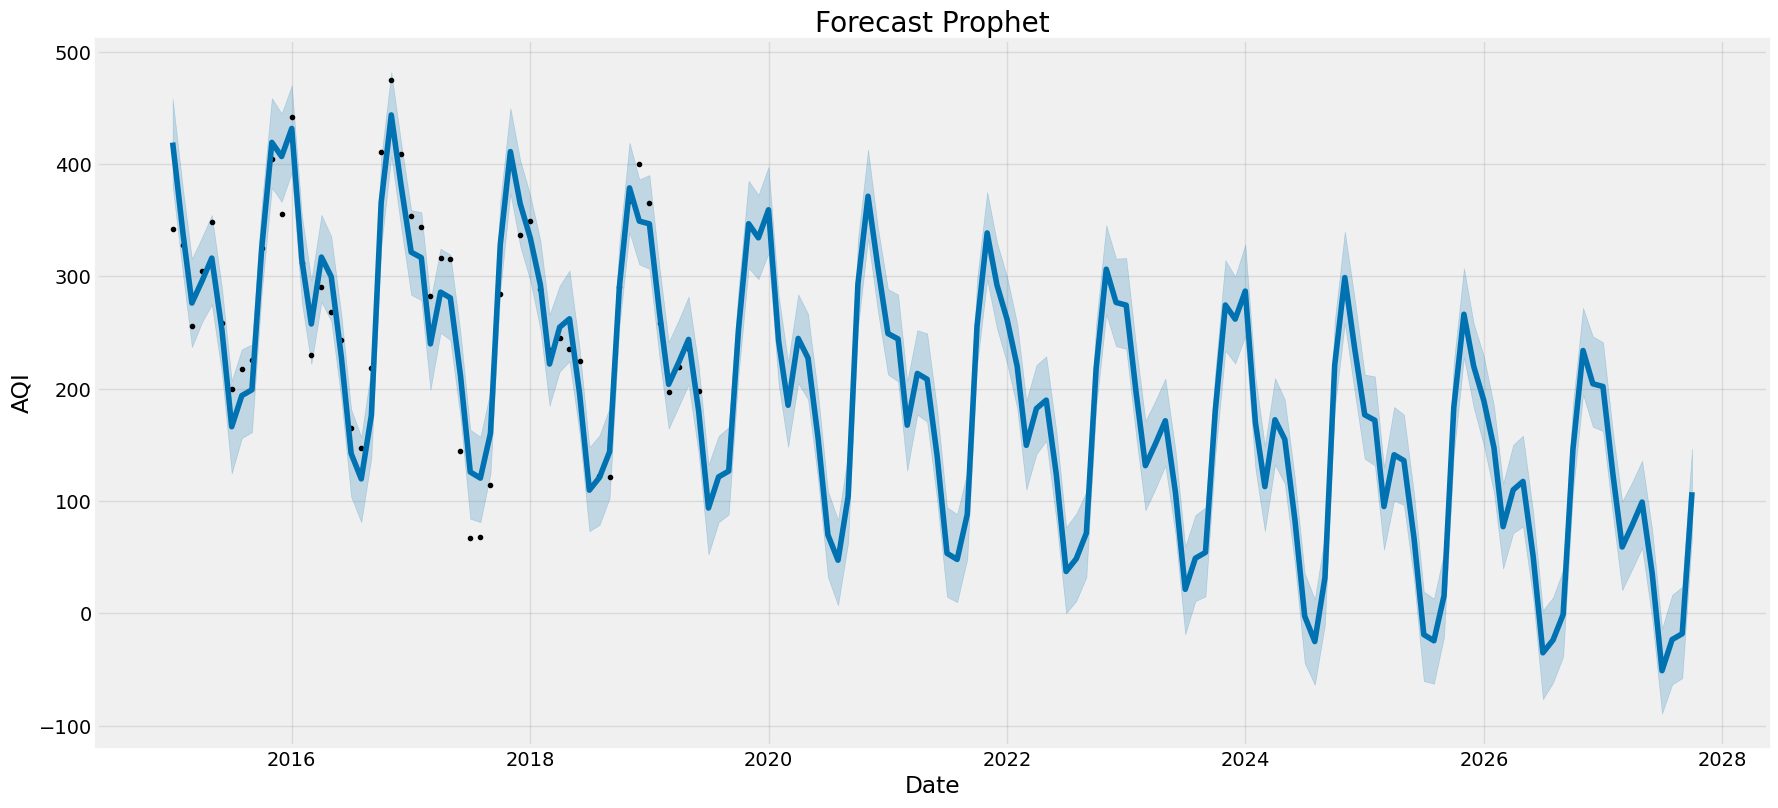

In [ ]:
future = m.make_future_dataframe(periods = 100,freq = 'MS')  #period: days you want to predict #freq monthly
forecast = m.predict(future)
m.plot(forecast, xlabel = 'Date', ylabel = 'AQI',figsize=(18,8))
plt.title('Forecast Prophet')

# Regression

Para aplicar modelos de regresión tenemos que abandonar el formato de time series y crear un dataframe con los lags y variables adicionales que consideremos para le modelo. <br>
Si utilizamos el lag-1 como variable, limitaremos la capacidad de realizar predicciones hasta tener los datos Por lo que es conveniente dejar varios lags de margen.

## Transform serie into Dataframe

In [ ]:
def transform_lags(serie,start_lag, end_lag):
    df = pd.DataFrame(serie)
    df.columns = ["y"]
    for lag in range(start_lag, end_lag):
        df["lag_{}".format(lag)] = df.y.shift(lag)   # Crea los lags
    return df

In [ ]:
data = transform_lags(ts_m,3,25)
data.shape

(67, 23)

In [ ]:
data.tail(5)

,y,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,135.838710,353.903226,356.100000,251.000000,106.533333,99.290323,145.096774,197.766667,235.838710,219.400000,...,400.387097,367.066667,290.419355,121.933333,122.064516,112.419355,224.366667,235.322581,245.533333,234.129032
2020-04-01,113.000000,308.451613,353.903226,356.100000,251.000000,106.533333,99.290323,145.096774,197.766667,235.838710,...,365.741935,400.387097,367.066667,290.419355,121.933333,122.064516,112.419355,224.366667,235.322581,245.533333
2020-05-01,148.645161,262.137931,308.451613,353.903226,356.100000,251.000000,106.533333,99.290323,145.096774,197.766667,...,258.178571,365.741935,400.387097,367.066667,290.419355,121.933333,122.064516,112.419355,224.366667,235.322581
2020-06-01,125.733333,135.838710,262.137931,308.451613,353.903226,356.100000,251.000000,106.533333,99.290323,145.096774,...,197.354839,258.178571,365.741935,400.387097,367.066667,290.419355,121.933333,122.064516,112.419355,224.366667
2020-07-01,101.000000,113.000000,135.838710,262.137931,308.451613,353.903226,356.100000,251.000000,106.533333,99.290323,...,219.400000,197.354839,258.178571,365.741935,400.387097,367.066667,290.419355,121.933333,122.064516,112.419355


Vamos a incluir ademas una variable que indique el dia de la semana y un indicador de fin de semana .Podriamos incluir la estacion del año o cualquier variable que consideremos guarda relacion con la prediccion:

In [ ]:
data['weekday'] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

In [ ]:
data.tail(5)

,y,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,weekday,is_weekend
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,135.838710,353.903226,356.100000,251.000000,106.533333,99.290323,145.096774,197.766667,235.838710,219.400000,...,290.419355,121.933333,122.064516,112.419355,224.366667,235.322581,245.533333,234.129032,6,1
2020-04-01,113.000000,308.451613,353.903226,356.100000,251.000000,106.533333,99.290323,145.096774,197.766667,235.838710,...,367.066667,290.419355,121.933333,122.064516,112.419355,224.366667,235.322581,245.533333,2,0
2020-05-01,148.645161,262.137931,308.451613,353.903226,356.100000,251.000000,106.533333,99.290323,145.096774,197.766667,...,400.387097,367.066667,290.419355,121.933333,122.064516,112.419355,224.366667,235.322581,4,0
2020-06-01,125.733333,135.838710,262.137931,308.451613,353.903226,356.100000,251.000000,106.533333,99.290323,145.096774,...,365.741935,400.387097,367.066667,290.419355,121.933333,122.064516,112.419355,224.366667,0,0
2020-07-01,101.000000,113.000000,135.838710,262.137931,308.451613,353.903226,356.100000,251.000000,106.533333,99.290323,...,258.178571,365.741935,400.387097,367.066667,290.419355,121.933333,122.064516,112.419355,2,0


## Split train-test

In [ ]:
X = data.dropna().drop('y',axis=1)
y = data.dropna().y

In [ ]:
X_train = X.iloc[:-test_size]
y_train = y.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_test = y.iloc[-test_size:]

## Rescaling

In [ ]:
# Estandarización: fit_transform() en train, transform() en test
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns, index=X_test.index)

## Train

In [ ]:
model_reg = Ridge()
model_reg.fit(X_train, y_train)

Ridge()

In [ ]:
def plotCoefficients(model): # Peso que tienen las variables
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

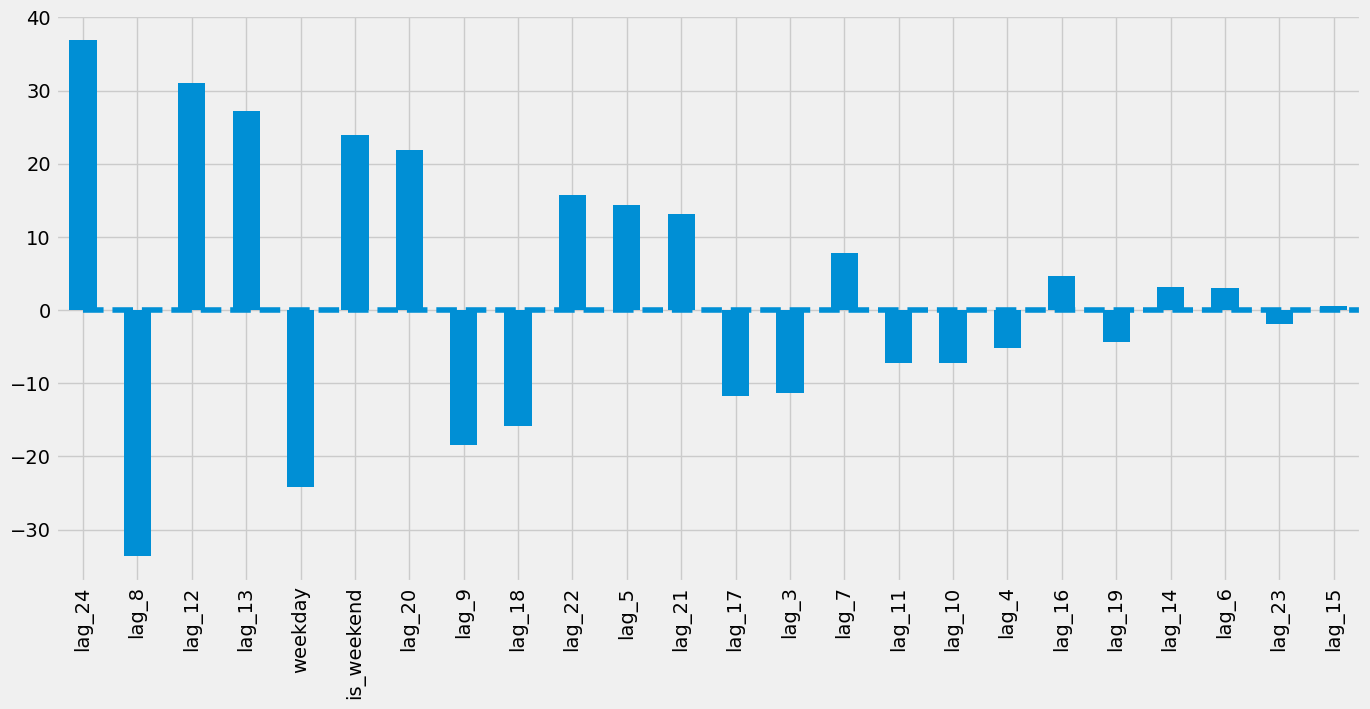

In [ ]:
#Visualiza peso de las variables en la regresion
plotCoefficients(model_reg)

In [ ]:
#Visualiza una fila ejemplo
X_train[-1:]

,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,weekday,is_weekend
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,-0.67192,-0.127534,0.866962,1.235654,1.011864,0.346031,-1.224639,-1.289383,-1.479521,-0.484915,...,0.615645,0.542304,1.224877,0.090668,-1.538703,-2.113741,-2.397028,-1.841227,0.959828,1.527525


## Evaluation


Normalmente en regresion aplicamos el modelo a los datos dentro del data test y evaluamos su performance. El problema de esto es que asume que se dispone de las variables del dia lag-n, y no podriamos comparar los resultados con los obtenidos en los modelos SARIMA o Prophet, los cuales sí realizan calculos de forecasting a largo. Por ello, vamos a implementar una funcion que haga forecast a partir de un modelo de regresión:
<br><br>
X[0] serán las variables del último registro en el training set, con ella calcularemos el primer predict y_forecast[0] el cual es parte de las variables que determinan y_forecast[1] y así sucesivamente...

In [ ]:
#Inicializa los valores de la funcion de forecast.
X_i = X_train.loc['2019-06-01']
y_forecast = y_train.copy()
idx = pd.date_range(start='2017-01-01', end='2020-07-01', freq='MS')
y_forecast = y_forecast.reindex(idx, fill_value=np.nan)

In [ ]:
# Forecast regression step by step:
for i in pd.date_range(start='2019-07-01', end='2020-07-01', freq='MS'):
    #Predict with last features
    pred_i = model_reg.predict([X_i])
    print(pred_i)
    y_forecast[i] = pred_i

    #Transform new lags into df
    data_pred = transform_lags(y_forecast,3,25)
    data_pred.drop('y',axis=1,inplace=True)

    #Add features
    data_pred['weekday'] = data_pred.index.weekday
    data_pred['is_weekend'] = data_pred.weekday.isin([5,6])*1


    #Standardize
    data_pred = pd.DataFrame(scaler.transform(data_pred),columns=data_pred.columns, index=data_pred.index)

    #Features for new predict
    X_i = data_pred.loc[i]

[162.90261406]
[95.76479741]
[22.47670874]
[60.14128195]
[207.97060979]
[317.14007556]
[369.13017419]
[371.74514258]
[310.9504738]
[179.08157055]
[156.18538946]
[153.03661143]
[255.37254979]


[]

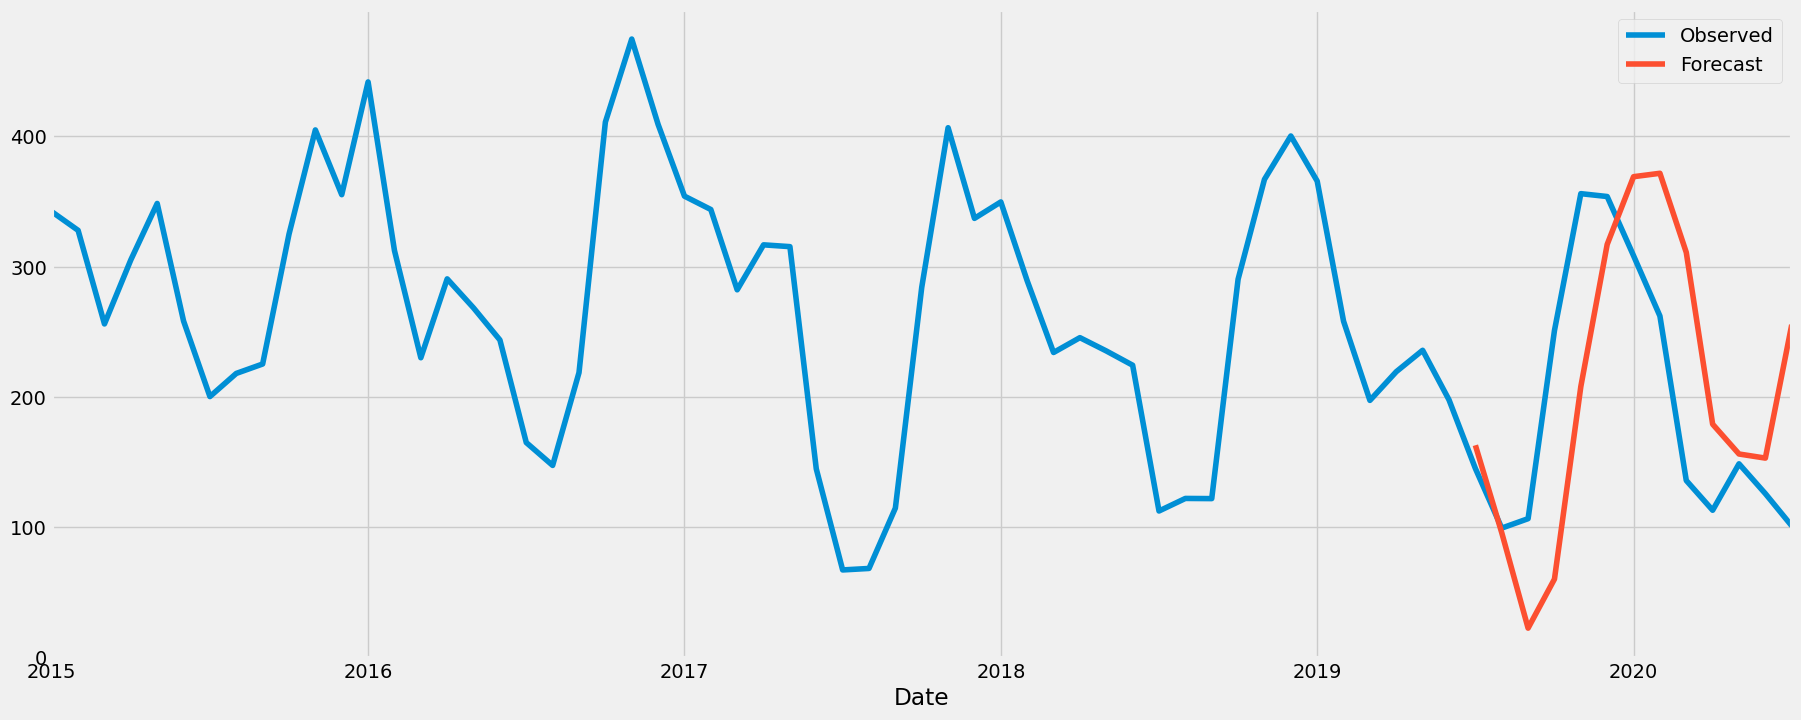

In [ ]:
#Plot results
ts_m.plot()
y_forecast[-test_size:].plot(figsize=(20,8))
plt.legend(['Observed','Forecast'])
plt.plot()

In [ ]:
#Evalua modelo
print('Eval metrics\n------------')
print('MAPE : '+str(round(MAPE(y_test, y_forecast[-test_size:]),2))+'%')
print('RMSE : '+str(round(RMSE(y_test, y_forecast[-test_size:]),2)))

Eval metrics
------------
MAPE : 50.1%
RMSE : 104.69


Observamos que se consiguen peores resultados, comprobamos que la ventaja de los modelos de Time series es su acierto a medio/largo plazo. Dependerá del objetivo del problema: si queremos una prediccion a corto los metodos de regresion pueden ser mas precisos si se ajustan adecuadamente mientras que a largo los modelos de series temporales univariantes estan optimizados para mantenerse dentro de una estacionariedad como hemos visto.